# ECG LSTM CGAN

## Data load

In [112]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import wfdb  # .dat 파일을 다루기 위한 라이브러리
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data.dataset import random_split
import matplotlib.pyplot as plt


class ECGDataset(Dataset):
    def __init__(self, directory):
        self.data = []
        segment_length = 1600 # 2초 길이의 샘플 수

        # 모든 환자 디렉터리 반복
        for patient_num in range(1, 93):
            patient_dir = os.path.join(directory, f"patient{patient_num:03d}")
            seg_files = [f for f in os.listdir(patient_dir) if f.endswith('.dat')]
            
            for seg_file in seg_files:
                data_file = os.path.join(patient_dir, seg_file)
                header_file = os.path.join(patient_dir, seg_file.replace('.dat', '.hea'))
                
                num_channels, samples_per_channel, channel_names = self.parse_header(header_file)
                ii_raw_index = channel_names.index('II-Raw')
                ii_index = channel_names.index('II')
                
                ecg_data = self.load_ecg_data(num_channels, samples_per_channel, data_file)
                
                # 각 세그먼트를 2초씩 잘라서 저장
                num_segments = 5
                for i in range(num_segments):
                    start = i * segment_length
                    end = start + segment_length
                    segment_data = {
                        "II-Raw": ecg_data[ii_raw_index][start:end],
                        "II": ecg_data[ii_index][start:end]
                    }

                    # 데이터 평균을 0으로 만들기
                    segment_data = {key: (value - np.mean(value)) / np.std(value) for key, value in segment_data.items()}
                    
                    self.data.append(segment_data)

    def parse_header(self, file_path):
        with open(file_path, 'r', encoding='latin1') as file:
            lines = file.readlines()
        num_channels = int(lines[0].split(' ')[1])
        samples_per_channel = int(lines[0].split(' ')[3])
        channel_names = []
        for line in lines[1:num_channels+1]:
            channel_info = line.split(' ')
            channel_names.append(channel_info[-1].strip())
        return num_channels, samples_per_channel, channel_names

    def load_ecg_data(self, num_channels, samples_per_channel, data_file):
        ecg_data = np.fromfile(data_file, dtype='int16')
        ecg_data = ecg_data.reshape((samples_per_channel, num_channels)).T
        return ecg_data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        return {key: torch.tensor(value, dtype=torch.float) for key, value in sample.items()}

# 데이터셋과 데이터 로더 설정
dataset_directory = './wilson-central-terminal-ecg-database-1.0.1'

ecg_dataset = ECGDataset(dataset_directory)

In [113]:
# 데이터셋의 전체 길이 확인
dataset_size = len(ecg_dataset)
print("데이터셋 크기:", dataset_size)

ecg1 = ecg_dataset[0]
ecg_signal_size = len(ecg1['II-Raw'])
print('신호 길이:', ecg_signal_size)

데이터셋 크기: 2700
신호 길이: 1600


In [114]:
ecg1['II-Raw'].shape

torch.Size([1600])

In [115]:
# 데이터셋의 길이를 구합니다.
total_size = len(ecg_dataset)

# 훈련 세트와 테스트 세트의 크기를 정합니다. 여기서는 80:20 비율을 사용합니다.
train_size = int(total_size * 0.8)
test_size = total_size - train_size

# random_split의 seed 고정
seed = torch.Generator().manual_seed(42)

# random_split을 사용하여 데이터셋을 나눕니다.
train_dataset, test_dataset = random_split(ecg_dataset, [train_size, test_size], generator=seed)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

## Conditional GAN

In [116]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

Using device: cuda


In [117]:
signal_dim = 1      # 1, 1600
noised_dim = 1      # 1, 1600

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.gen_encoder1 = nn.Conv1d(1, 8, kernel_size=5, stride=1, padding=2)     # (batch, 1, 1600) -> (batch, 8, 1600)
        self.gen_encoder2 = nn.Conv1d(8, 16, kernel_size=5, stride=2, padding=2)    # (batch, 8, 1600) -> (batch, 16, 800)
        self.gen_encoder3 = nn.Conv1d(16, 32, kernel_size=5, stride=2, padding=2)   # (batch, 16, 800) -> (batch, 32, 400)

        self.lstm = nn.LSTM(input_size=32, hidden_size=32, num_layers=1, batch_first=True)  # LSTM layer

        self.dropout = nn.Dropout(0.5)

        self.gen_decoder1 = nn.ConvTranspose1d(32, 16, kernel_size=5, stride=2, padding=2, output_padding=1)    # (batch, 32, 400) -> (batch, 16, 800)
        self.gen_decoder2 = nn.ConvTranspose1d(16, 8, kernel_size=5, stride=2, padding=2, output_padding=1)     # (batch, 16, 800) -> (batch, 8, 1600)
        self.gen_decoder3 = nn.ConvTranspose1d(8, 1, kernel_size=5, stride=1, padding=2)                        # (batch, 8, 1600) -> (batch, 1, 1600)

    def forward(self, noised_signal):
        z = F.leaky_relu(self.gen_encoder1(noised_signal), 0.2)
        z = F.leaky_relu(self.gen_encoder2(z), 0.2)
        z = F.leaky_relu(self.gen_encoder3(z), 0.2)

        z = z.transpose(1, 2)
        z, _ = self.lstm(z)
        z = z.transpose(1, 2)

        z = self.dropout(z)

        z = F.leaky_relu(self.gen_decoder1(z), 0.2)
        z = F.leaky_relu(self.gen_decoder2(z), 0.2)
        output = self.gen_decoder3(z)        
        return output


class Discriminator(nn.Module):
    def __init__(self, signal_dim, noised_dim):
        super(Discriminator, self).__init__()

        self.conv1 = nn.Conv1d(signal_dim + noised_dim, 8, kernel_size=3, stride=1, padding=1)    
        self.pool1 = nn.MaxPool1d(kernel_size=2, stride=2, padding=0)                               # (batch, 2, 1600) -> (batch, 8, 800)

        self.conv2 = nn.Conv1d(8, 16, kernel_size=3, stride=1, padding=1)                           
        self.pool2 = nn.MaxPool1d(kernel_size=2, stride=2, padding=0)                               # (batch, 8, 800) -> (batch, 16, 400)

        self.conv3 = nn.Conv1d(16, 32, kernel_size=3, stride=1, padding=1)                          
        self.pool3 = nn.MaxPool1d(kernel_size=2, stride=2, padding=0)                               # (batch, 16, 400) -> (batch, 32, 200)

        self.conv4 = nn.Conv1d(32, 64, kernel_size=3, stride=1, padding=1)                          
        self.pool4 = nn.MaxPool1d(kernel_size=2, stride=2, padding=0)                               # (batch, 32, 200) -> (batch, 64, 100)

        self.lstm = nn.LSTM(input_size=64, hidden_size=32, num_layers=1, batch_first=True)          # LSTM layer
        self.fc_encoder = nn.Linear(32*100, 1)

    def forward(self, x, condition):
        x = torch.cat([x, condition], dim=1)                # x(batch, 1, 1600), condition(batch, 1, 1600) => (batch, 2, 1600)

        x = F.leaky_relu(self.conv1(x), 0.2)
        x = self.pool1(x)
        x = F.leaky_relu(self.conv2(x), 0.2)
        x = self.pool2(x)
        x = F.leaky_relu(self.conv3(x), 0.2)
        x = self.pool3(x)
        x = F.leaky_relu(self.conv4(x), 0.2)
        x = self.pool4(x)

        x = x.transpose(1, 2)
        x, _ = self.lstm(x)
        x = x.transpose(1, 2)

        x = torch.flatten(x, start_dim=1)

        output = torch.sigmoid(self.fc_encoder(x))
        return output

In [118]:
# 하이퍼파라미터 설정
num_epochs = 200
learning_rate = 0.0001

In [119]:
# 모델 및 최적화 알고리즘 설정
generator = Generator().to(device)
discriminator = Discriminator(signal_dim, noised_dim).to(device)

optimizer_G = torch.optim.Adam(generator.parameters(), lr=learning_rate)
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=learning_rate)

# 손실 함수(loss function)
criterion_GAN = nn.BCELoss(reduction='mean')
criterion_pixelwise = nn.L1Loss(reduction='mean')

In [120]:
# 훈련 루프
def train(train_loader):
    generator.train()
    discriminator.train()
    
    for epoch in range(num_epochs):
        for i, data in enumerate(train_loader):
            real = torch.ones(data['II'].shape[0]).reshape(-1, 1).to(device)   # 진짜(real): 1
            fake = torch.zeros(data['II'].shape[0]).reshape(-1, 1).to(device)  # 가짜(fake): 0

            denoised_signal = data['II'].unsqueeze(1).float().to(device)            # (batch, 1600) -> (batch, 1, 1600)
            noised_signal = data['II-Raw'].unsqueeze(1).float().to(device)          # (batch, 1600) -> (batch, 1, 1600)

            """ 생성자(generator)를 학습 """
            optimizer_G.zero_grad()

            generated_signal = generator(noised_signal)
            pred_fake = discriminator(generated_signal, noised_signal)

            loss_GAN = criterion_GAN(pred_fake, real)
            loss_pixel = criterion_pixelwise(generated_signal, denoised_signal)

            loss_G = loss_GAN + 50*loss_pixel

            loss_G.backward()

            optimizer_G.step()


            """ 판별자(discriminator)를 학습 """
            optimizer_D.zero_grad()

            pred_real = discriminator(denoised_signal, noised_signal)
            loss_real = criterion_GAN(pred_real, real)

            pred_fake = discriminator(generated_signal.detach(), noised_signal)
            loss_fake = criterion_GAN(pred_fake, fake)

            # Total loss
            loss_D = 0.5 * (loss_real + loss_fake)

            loss_D.backward()
            optimizer_D.step()
            
        print(f'Epoch {epoch + 1}/{num_epochs}, Pixel Loss: {loss_pixel.item()}, Generator Loss: {loss_G.item()}, Discriminator Loss: {loss_D.item()}')

# 훈련 시작
train(train_loader)

Epoch 1/200, Pixel Loss: 0.4505506455898285, Generator Loss: 6.838533401489258, Discriminator Loss: 0.12991711497306824
Epoch 2/200, Pixel Loss: 0.46029016375541687, Generator Loss: 5.833558082580566, Discriminator Loss: 0.4644419550895691
Epoch 3/200, Pixel Loss: 0.3689291179180145, Generator Loss: 4.414675712585449, Discriminator Loss: 0.5367271900177002
Epoch 4/200, Pixel Loss: 0.32541075348854065, Generator Loss: 3.9622535705566406, Discriminator Loss: 0.5793318748474121
Epoch 5/200, Pixel Loss: 0.30262649059295654, Generator Loss: 3.8403615951538086, Discriminator Loss: 0.5989984273910522
Epoch 6/200, Pixel Loss: 0.28841665387153625, Generator Loss: 3.7313590049743652, Discriminator Loss: 0.6940193772315979
Epoch 7/200, Pixel Loss: 0.3798489570617676, Generator Loss: 5.305574417114258, Discriminator Loss: 0.2786686420440674
Epoch 8/200, Pixel Loss: 0.31584522128105164, Generator Loss: 3.9041929244995117, Discriminator Loss: 0.6355509757995605
Epoch 9/200, Pixel Loss: 0.30162352323

In [121]:
def evaluate(test_loader):
    generator.eval()
    discriminator.eval()
    
    total_g_loss = 0.0
    total_d_loss = 0.0
    total_pixel_loss = 0.0
    
    with torch.no_grad():
        for i, data in enumerate(test_loader):
            real = torch.ones(data['II'].shape[0]).reshape(-1, 1).to(device)  # 진짜(real): 1
            fake = torch.zeros(data['II'].shape[0]).reshape(-1, 1).to(device) # 가짜(fake): 0

            denoised_signal = data['II'].unsqueeze(1).float().to(device)      # (batch, 1600) -> (batch, 1, 1600)
            noised_signal = data['II-Raw'].unsqueeze(1).float().to(device)    # (batch, 1600) -> (batch, 1, 1600)

            # 생성자 평가
            generated_signal = generator(noised_signal)
            pred_fake = discriminator(generated_signal, noised_signal)
            loss_GAN = criterion_GAN(pred_fake, real)
            loss_pixel = criterion_pixelwise(generated_signal, denoised_signal)
            loss_G = loss_GAN + 50*loss_pixel
            
            total_g_loss += loss_G.item()
            total_pixel_loss += loss_pixel.item()

            # 판별자 평가
            pred_real = discriminator(denoised_signal, noised_signal)
            loss_real = criterion_GAN(pred_real, real)

            pred_fake = discriminator(generated_signal, noised_signal)
            loss_fake = criterion_GAN(pred_fake, fake)

            loss_D = 0.5 * (loss_real + loss_fake)
            total_d_loss += loss_D.item()

    avg_g_loss = total_g_loss / len(test_loader)
    avg_d_loss = total_d_loss / len(test_loader)
    avg_pixel_loss = total_pixel_loss / len(test_loader)

    print(f'Test set evaluation - Pixel Loss: {avg_pixel_loss:.5f}, Generator Loss: {avg_g_loss:.5f}, Discriminator Loss: {avg_d_loss:.5f}')
    
# 테스트 셋 평가
evaluate(test_loader)

Test set evaluation - Pixel Loss: 0.26215, Generator Loss: 11.07295, Discriminator Loss: 0.09382


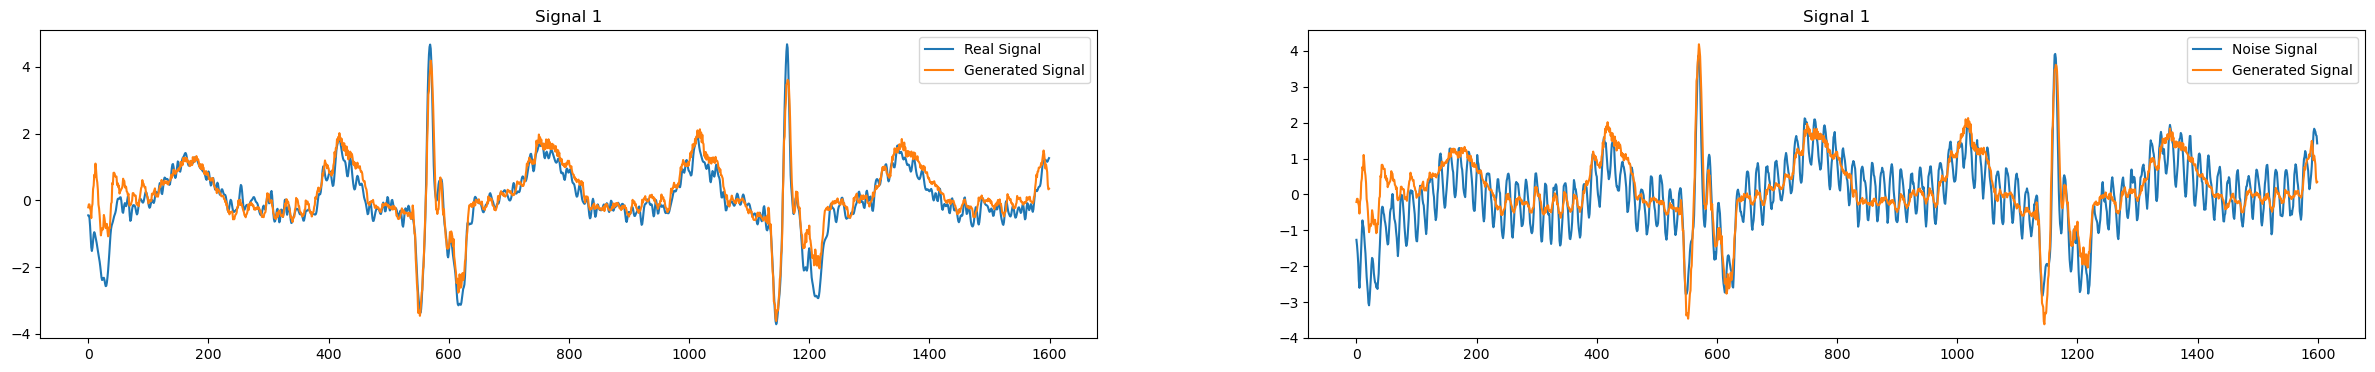

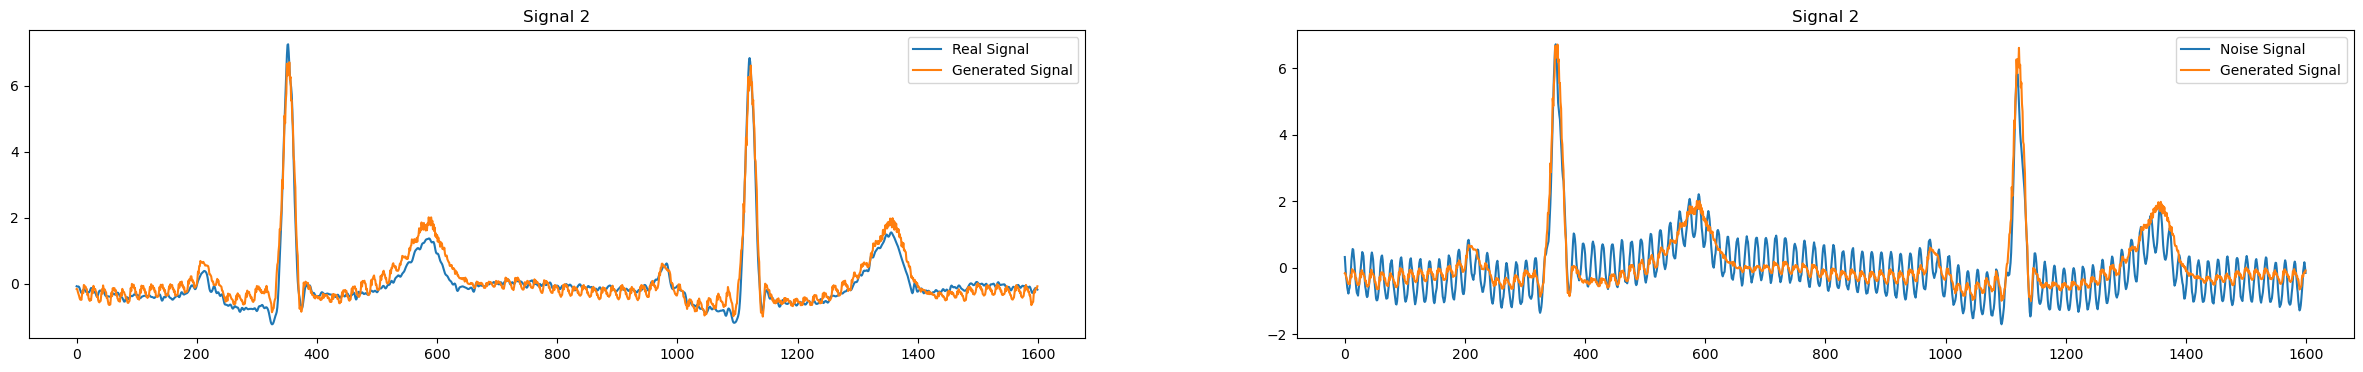

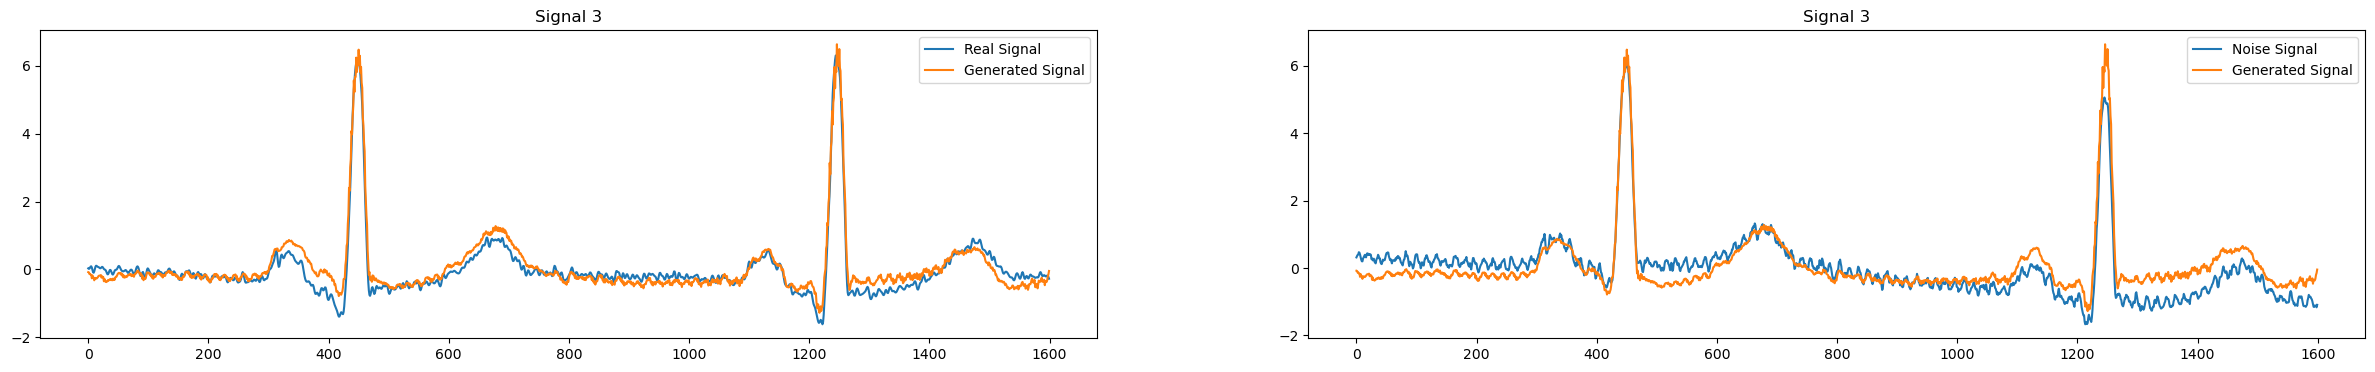

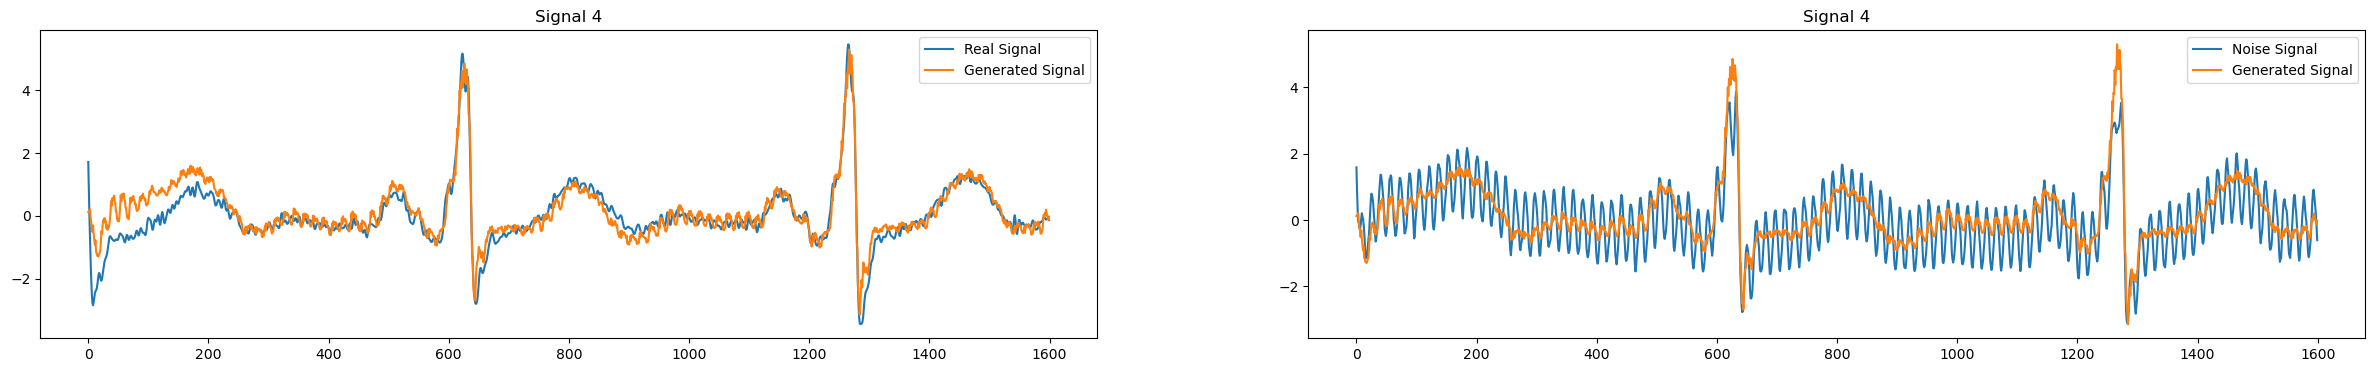

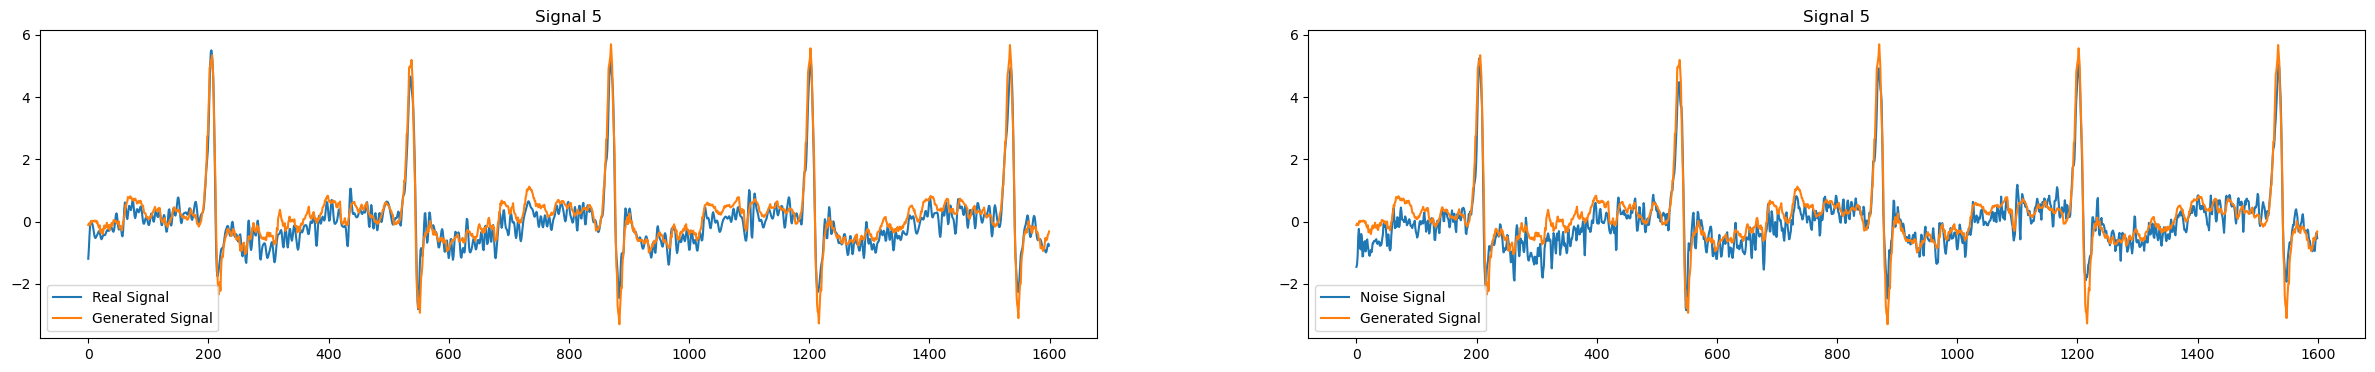

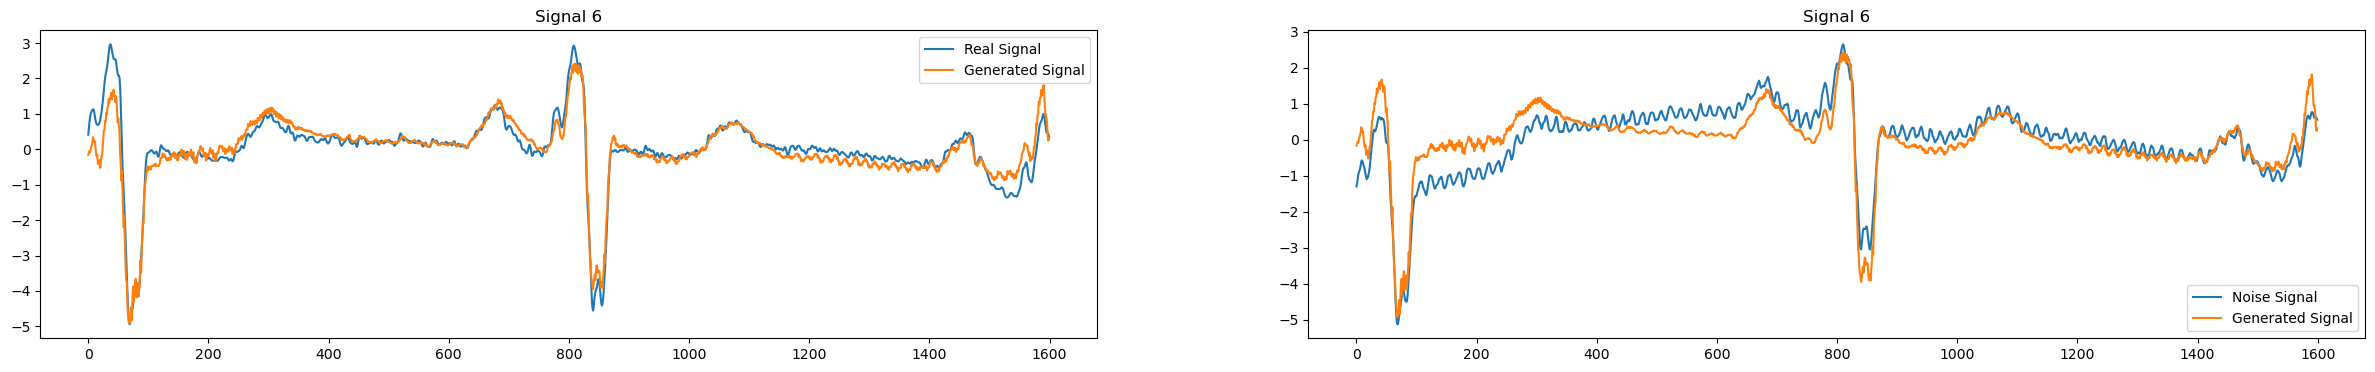

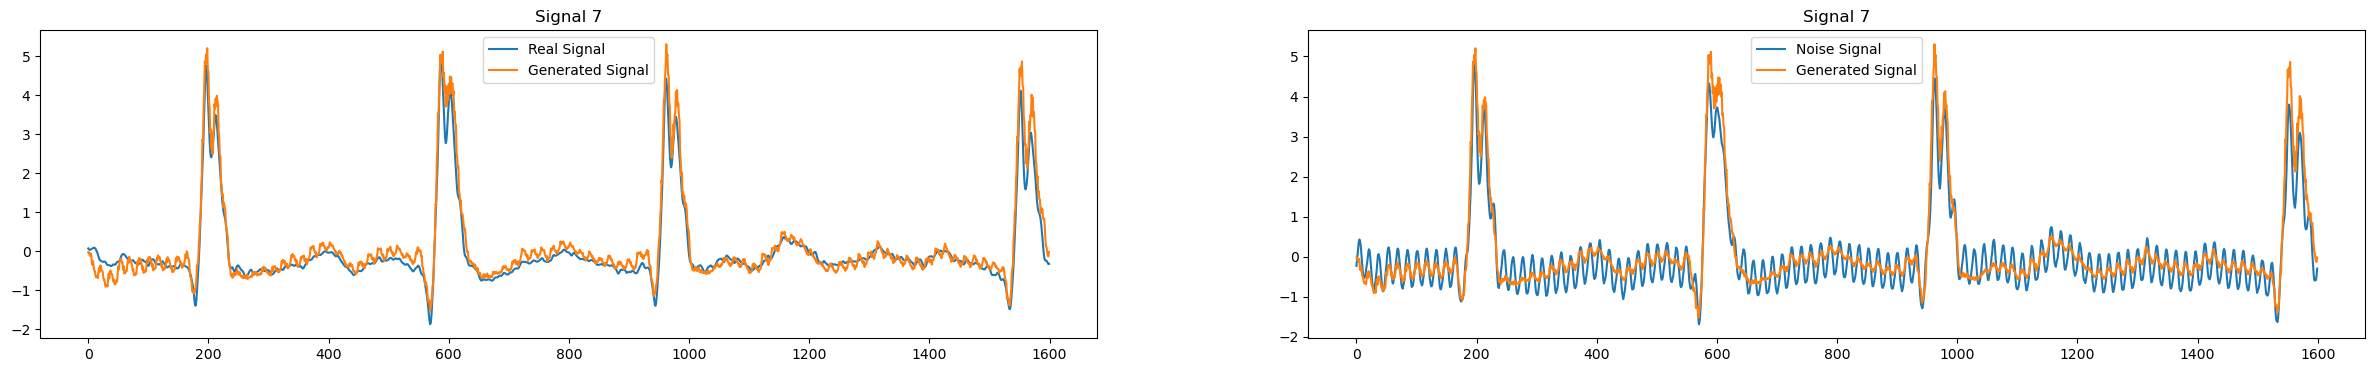

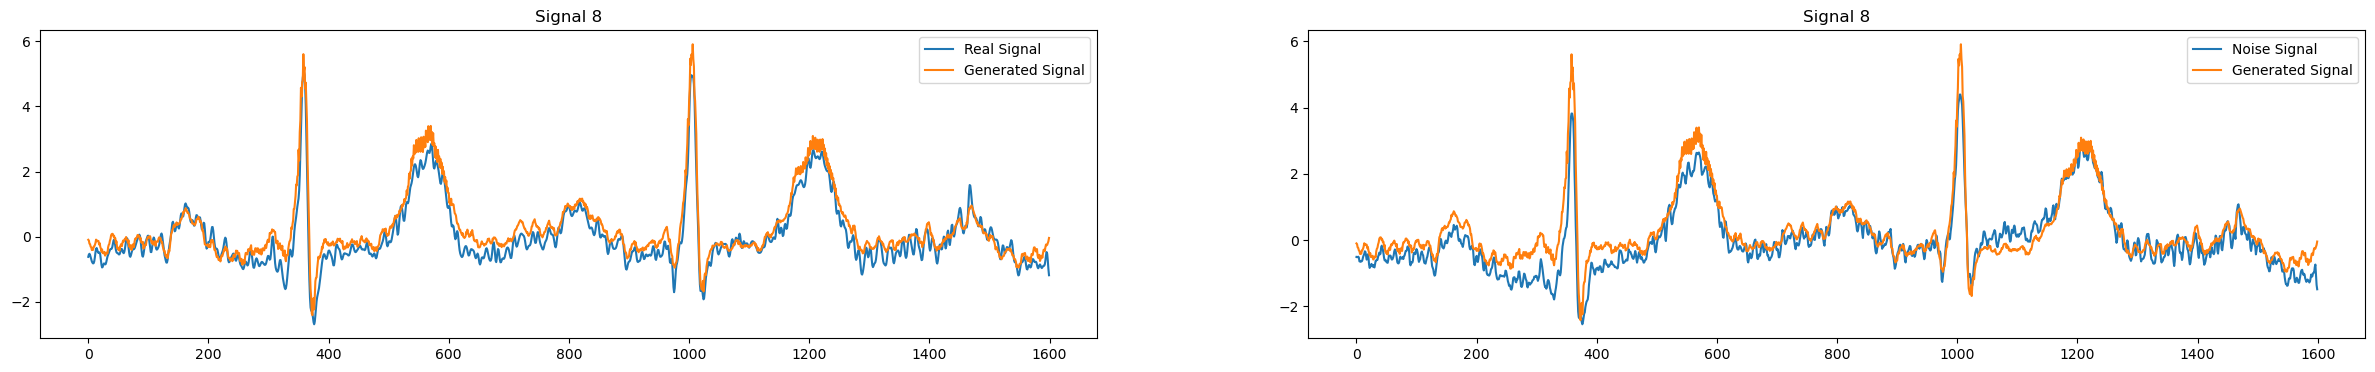

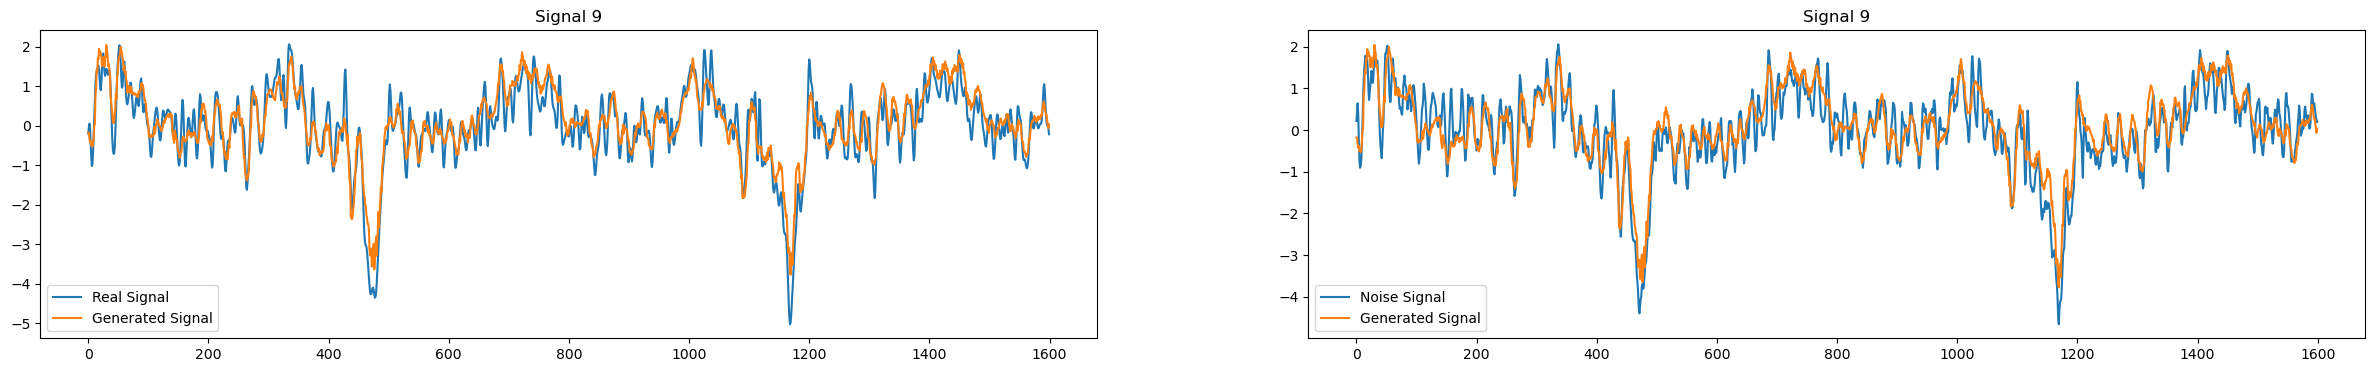

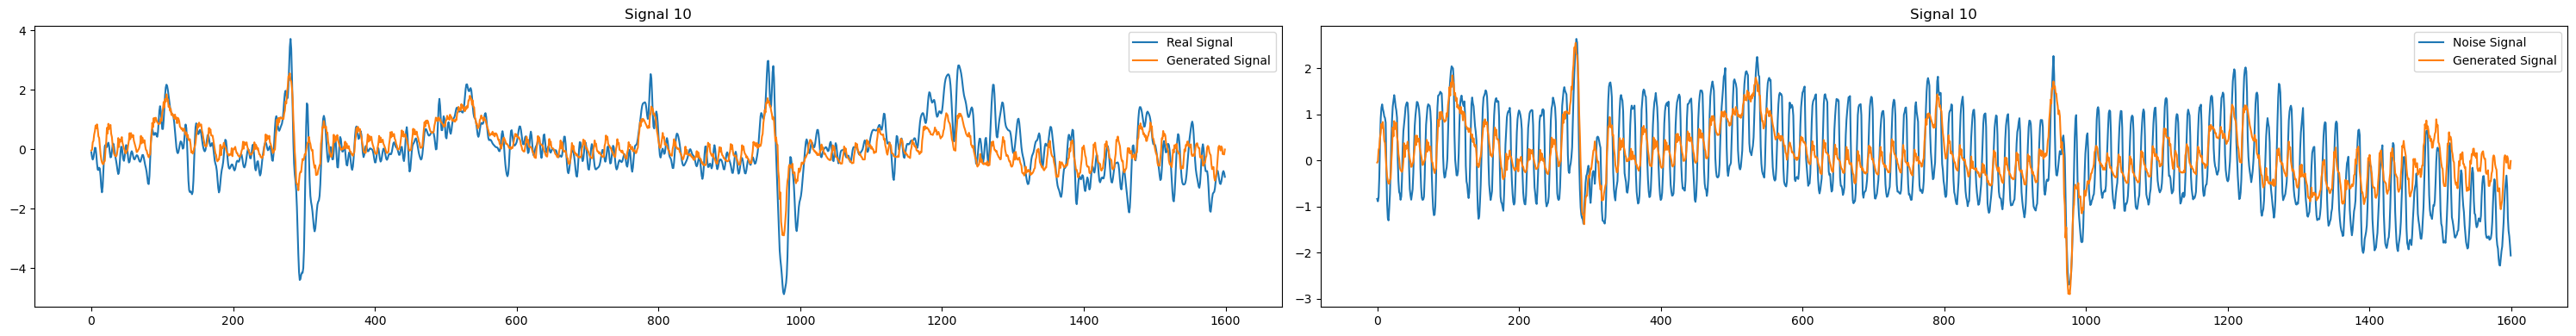

In [122]:
def plot_signals(real_signals, noise_signals, generated_signals, num_examples=10):
    for i in range(num_examples):
        plt.figure(figsize=(30, 4))
        plt.subplot(1, 2, 1)
        plt.plot(real_signals[i], label='Real Signal')
        plt.plot(generated_signals[i], label='Generated Signal')
        plt.legend()
        plt.title(f'Signal {i+1}')

        plt.subplot(1, 2, 2)
        plt.plot(noise_signals[i], label='Noise Signal')
        plt.plot(generated_signals[i], label='Generated Signal')
        plt.legend()
        plt.title(f'Signal {i+1}')
    plt.tight_layout()
    plt.show()

def visualize_test_results(data_loader):
    generator.eval()  # 생성기를 평가 모드로 설정
    real_data_samples = []
    noise_data_samples = []
    generated_data_samples = []
    
    with torch.no_grad():
        for data in data_loader:
            real_signal = data['II'].unsqueeze(1).float().to(device)
            noise_signal = data['II-Raw'].unsqueeze(1).float().to(device)

            generated_signal = generator(noise_signal).cpu().numpy()
            noise_signal = noise_signal.cpu().numpy()
            real_signal = real_signal.cpu().numpy()

            real_data_samples.append(real_signal)
            noise_data_samples.append(noise_signal)
            generated_data_samples.append(generated_signal)
            
            if len(real_data_samples) >= 5:
                break

    # 리스트에서 numpy 배열로 변환
    real_data_samples = np.array(real_data_samples).reshape(-1, 1600)
    noise_data_samples = np.array(noise_data_samples).reshape(-1, 1600)
    generated_data_samples = np.array(generated_data_samples).reshape(-1, 1600)
    
    plot_signals(real_data_samples, noise_data_samples, generated_data_samples)

# 시각화 실행
visualize_test_results(test_loader)

---

## Gaussian Noise

alpha = 0.1

In [123]:
class GN_ECGDataset(Dataset):
    def __init__(self, directory, alpha):
        self.data = []
        segment_length = 1600  # 2초 길이의 샘플 수

        # 모든 환자 디렉터리 반복
        for patient_num in range(1, 93):
            patient_dir = os.path.join(directory, f"patient{patient_num:03d}")
            seg_files = [f for f in os.listdir(patient_dir) if f.endswith('.dat')]
            
            for seg_file in seg_files:
                data_file = os.path.join(patient_dir, seg_file)
                header_file = os.path.join(patient_dir, seg_file.replace('.dat', '.hea'))
                
                num_channels, samples_per_channel, channel_names = self.parse_header(header_file)
                ii_index = channel_names.index('II')
                
                ecg_data = self.load_ecg_data(num_channels, samples_per_channel, data_file)
                
                # 각 세그먼트를 2초씩 잘라서 저장
                num_segments = 5
                for i in range(num_segments):
                    start = i * segment_length
                    end = start + segment_length
                    segment_data = {
                        "II": ecg_data[ii_index][start:end]
                    }

                    # II 채널 표준화
                    segment_data["II"] = (segment_data["II"] - np.mean(segment_data["II"])) / np.std(segment_data["II"])

                    # Gaussian noise 추가하여 II-Raw 생성
                    noise = np.random.normal(0, 1, segment_length)
                    segment_data["II-Raw"] = segment_data["II"] + alpha*noise

                    self.data.append(segment_data)

    def parse_header(self, file_path):
        with open(file_path, 'r', encoding='latin1') as file:
            lines = file.readlines()
        num_channels = int(lines[0].split(' ')[1])
        samples_per_channel = int(lines[0].split(' ')[3])
        channel_names = []
        for line in lines[1:num_channels+1]:
            channel_info = line.split(' ')
            channel_names.append(channel_info[-1].strip())
        return num_channels, samples_per_channel, channel_names

    def load_ecg_data(self, num_channels, samples_per_channel, data_file):
        ecg_data = np.fromfile(data_file, dtype='int16')
        ecg_data = ecg_data.reshape((samples_per_channel, num_channels)).T
        return ecg_data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        return {key: torch.tensor(value, dtype=torch.float) for key, value in sample.items()}

# 데이터셋과 데이터 로더 설정
GN_01_ecg_dataset = GN_ECGDataset(dataset_directory, 0.1)

# random_split을 사용하여 데이터셋을 나눕니다.
seed = torch.Generator().manual_seed(42)
train_dataset, test_dataset = random_split(GN_01_ecg_dataset, [train_size, test_size], generator=seed)

GN_01_train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
GN_01_test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [124]:
# 모델 및 최적화 알고리즘 설정
generator = Generator().to(device)
discriminator = Discriminator(signal_dim, noised_dim).to(device)

optimizer_G = torch.optim.Adam(generator.parameters(), lr=learning_rate)
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=learning_rate)

# 손실 함수(loss function)
criterion_GAN = nn.BCELoss(reduction='mean')
criterion_pixelwise = nn.L1Loss(reduction='mean')

In [125]:
train(GN_01_train_loader)

Epoch 1/200, Pixel Loss: 0.47854506969451904, Generator Loss: 7.643340110778809, Discriminator Loss: 0.10062901675701141
Epoch 2/200, Pixel Loss: 0.40204328298568726, Generator Loss: 7.364978790283203, Discriminator Loss: 0.13824956119060516
Epoch 3/200, Pixel Loss: 0.17282520234584808, Generator Loss: 7.07763147354126, Discriminator Loss: 0.46659207344055176
Epoch 4/200, Pixel Loss: 0.12659861147403717, Generator Loss: 5.339139461517334, Discriminator Loss: 0.1432117223739624
Epoch 5/200, Pixel Loss: 0.13633853197097778, Generator Loss: 9.143521308898926, Discriminator Loss: 0.16048935055732727
Epoch 6/200, Pixel Loss: 0.09577178955078125, Generator Loss: 3.896416664123535, Discriminator Loss: 0.2742154896259308
Epoch 7/200, Pixel Loss: 0.09772495180368423, Generator Loss: 5.669199466705322, Discriminator Loss: 0.36999034881591797
Epoch 8/200, Pixel Loss: 0.10172608494758606, Generator Loss: 8.073137283325195, Discriminator Loss: 0.19672200083732605
Epoch 9/200, Pixel Loss: 0.10534746

In [126]:
evaluate(GN_01_test_loader)

Test set evaluation - Pixel Loss: 0.05425, Generator Loss: 20.39260, Discriminator Loss: 1.00080


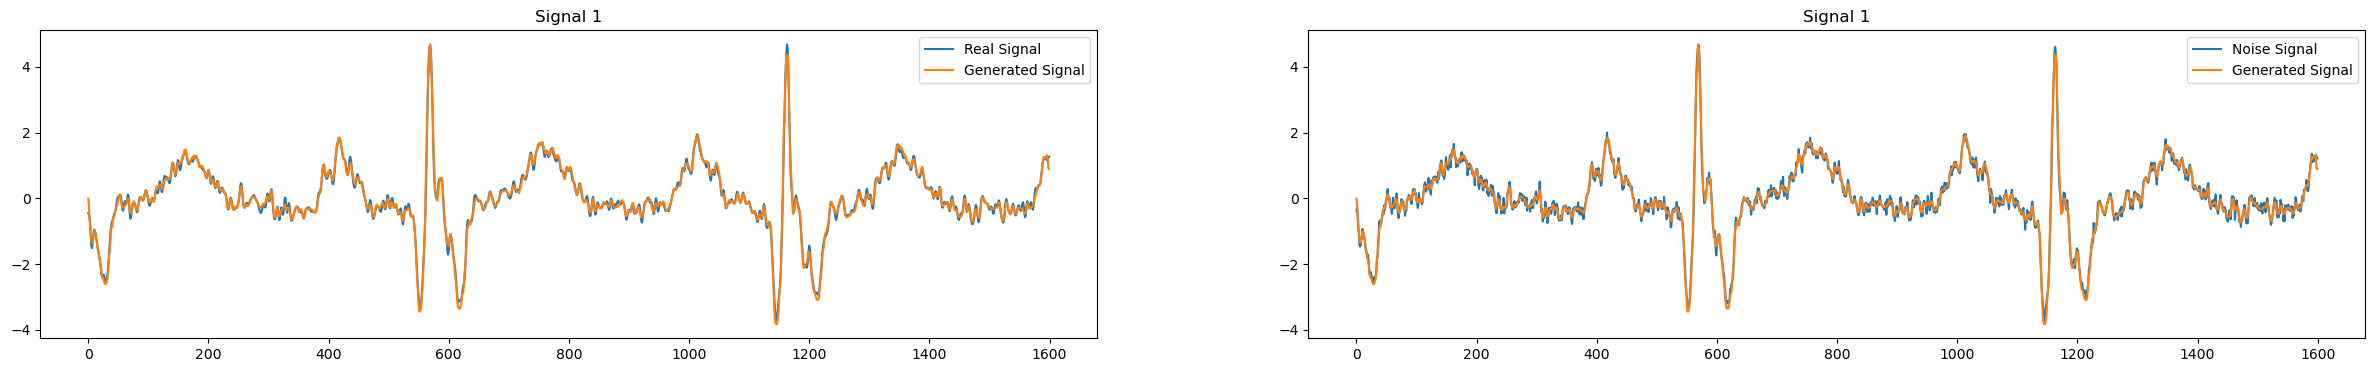

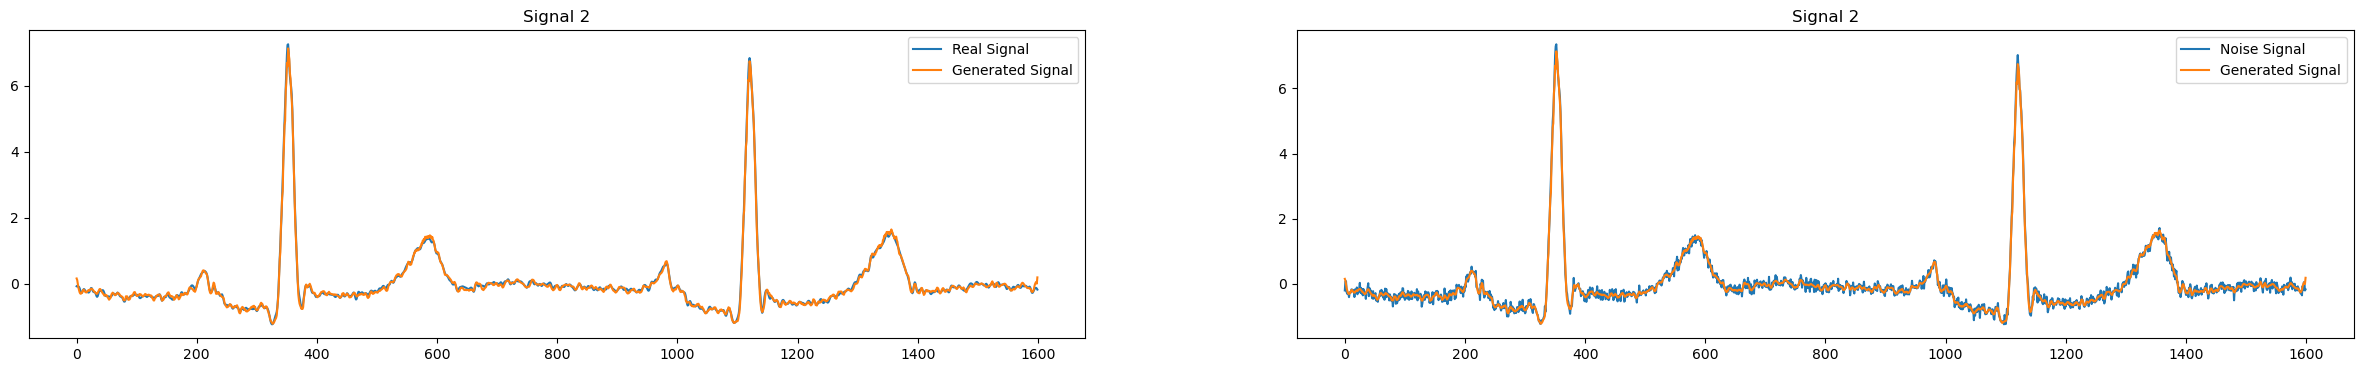

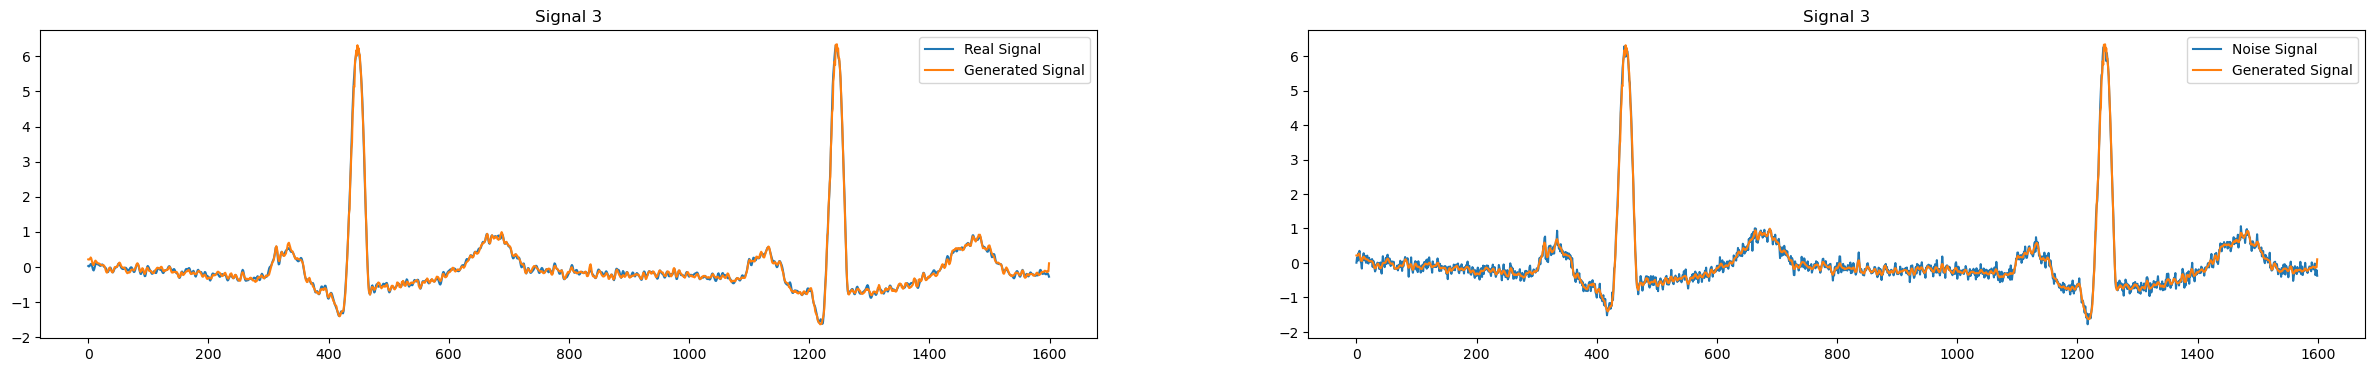

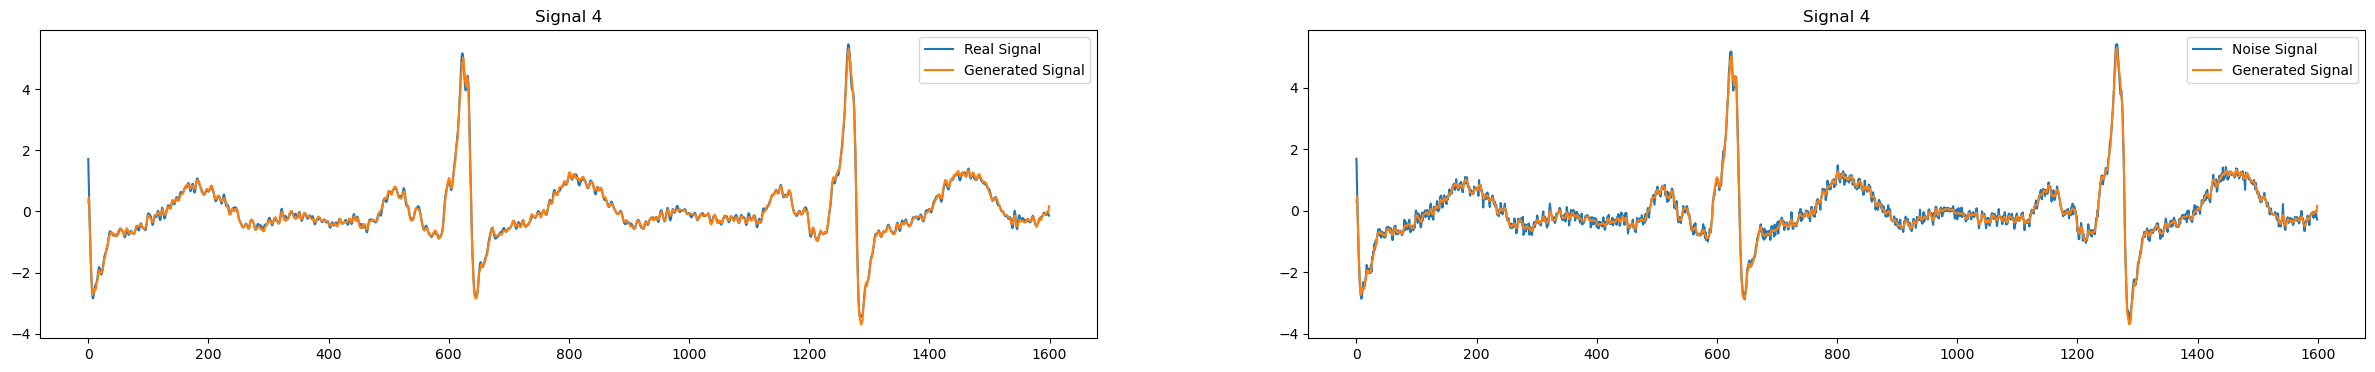

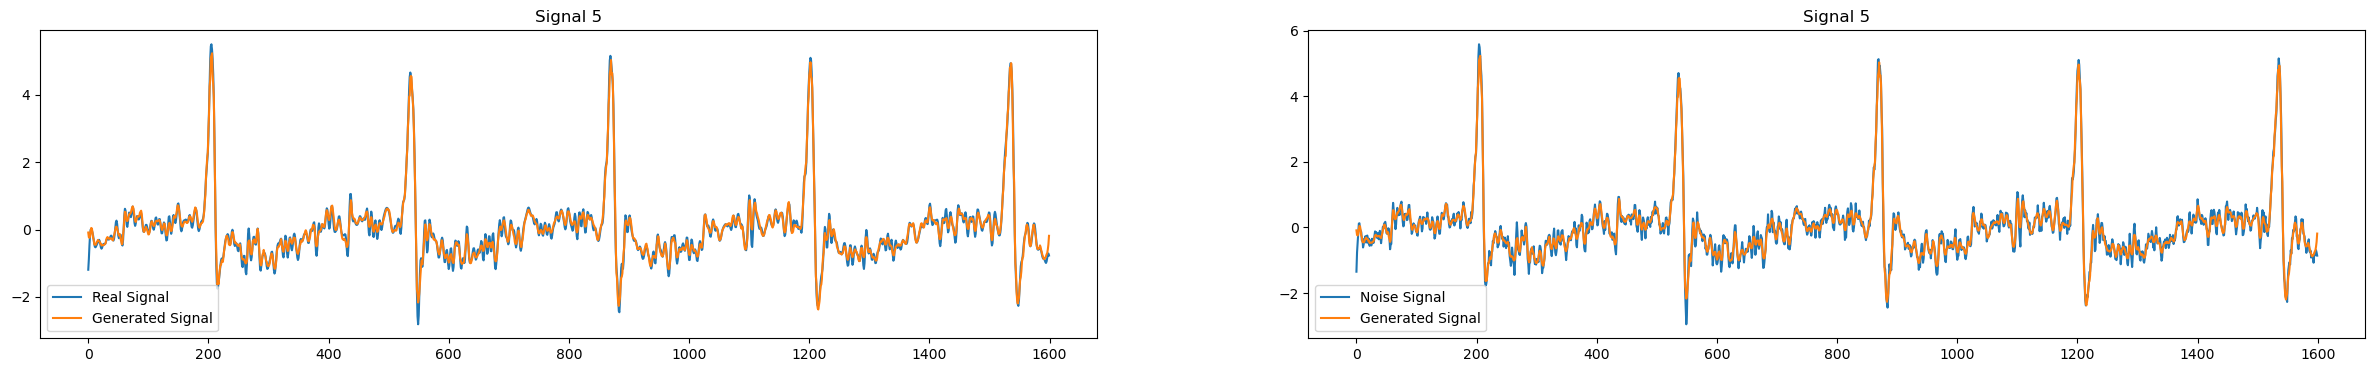

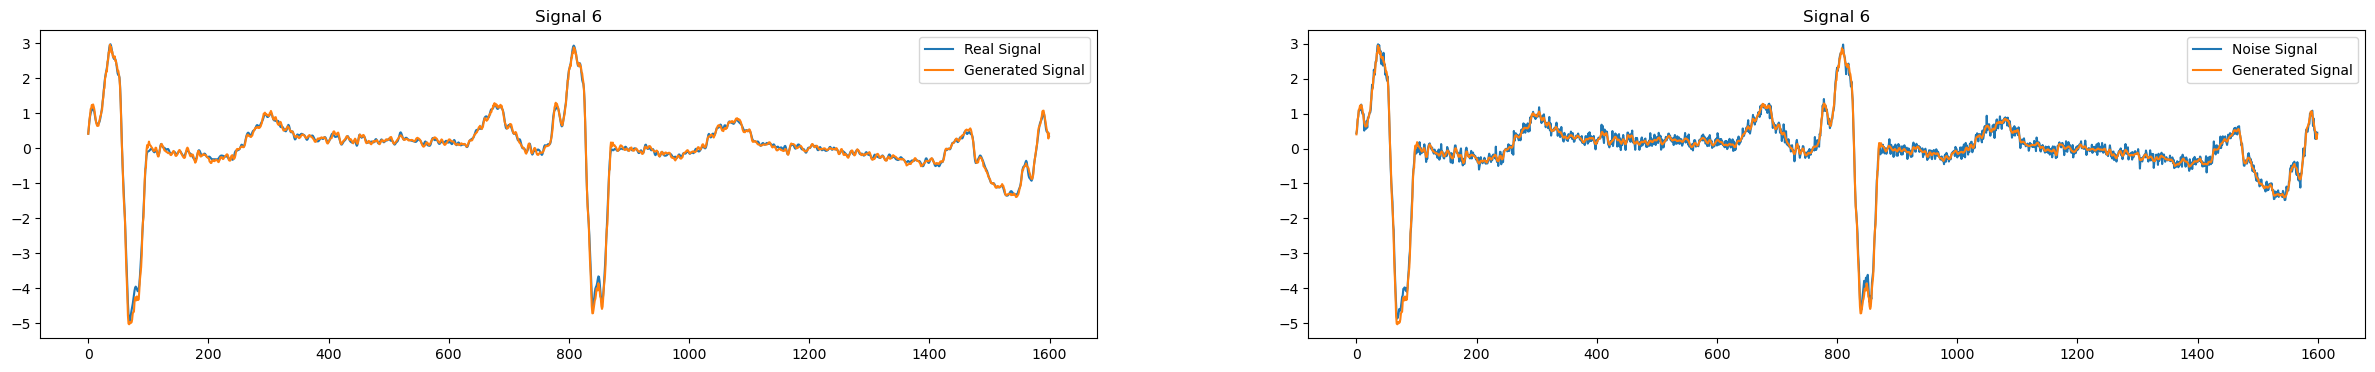

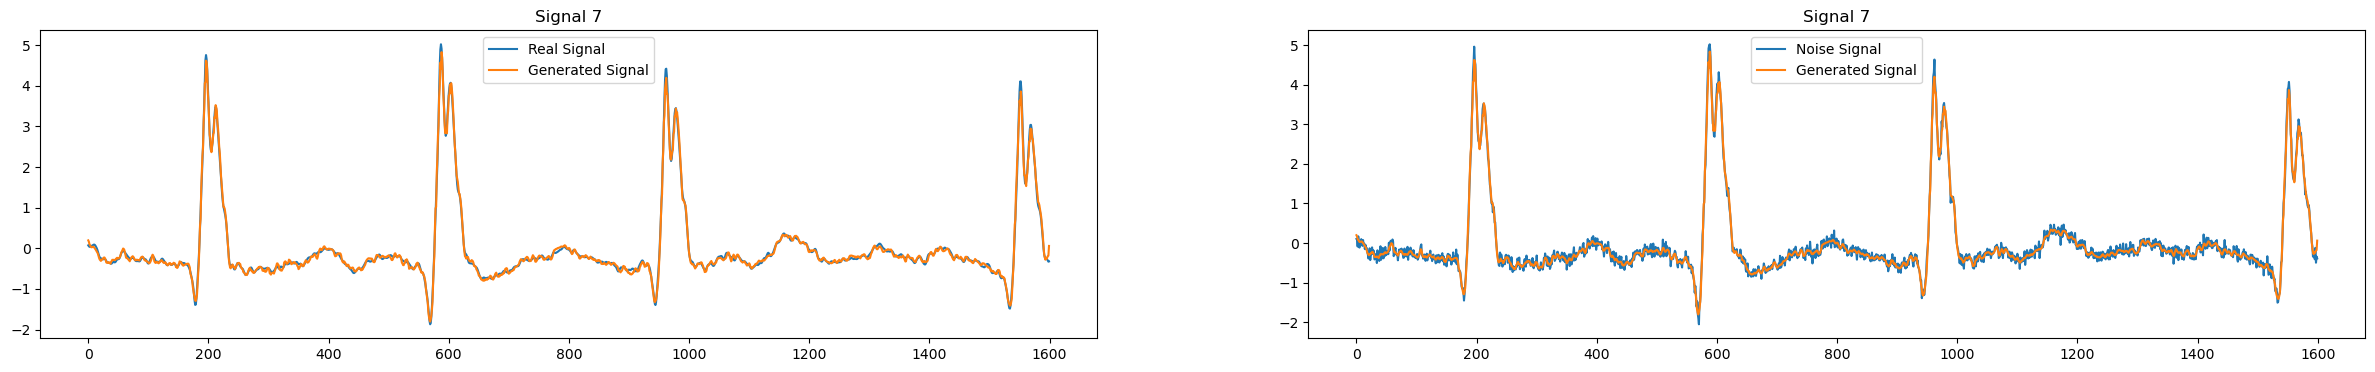

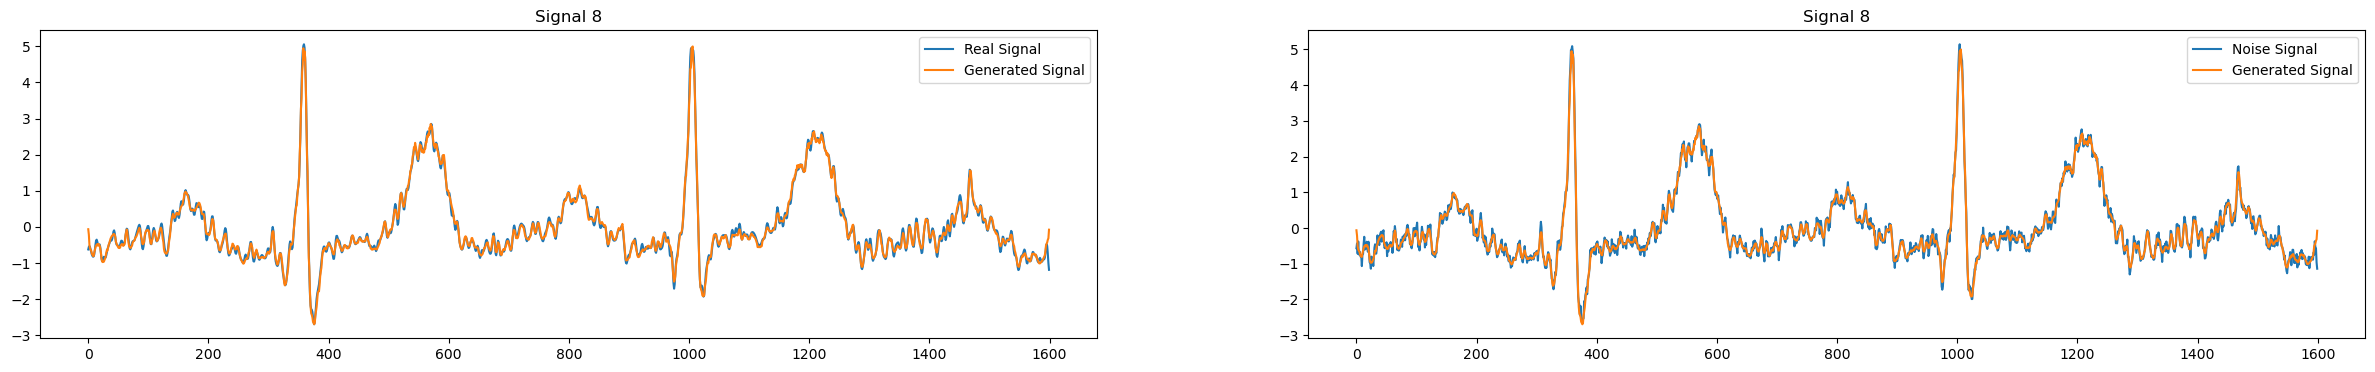

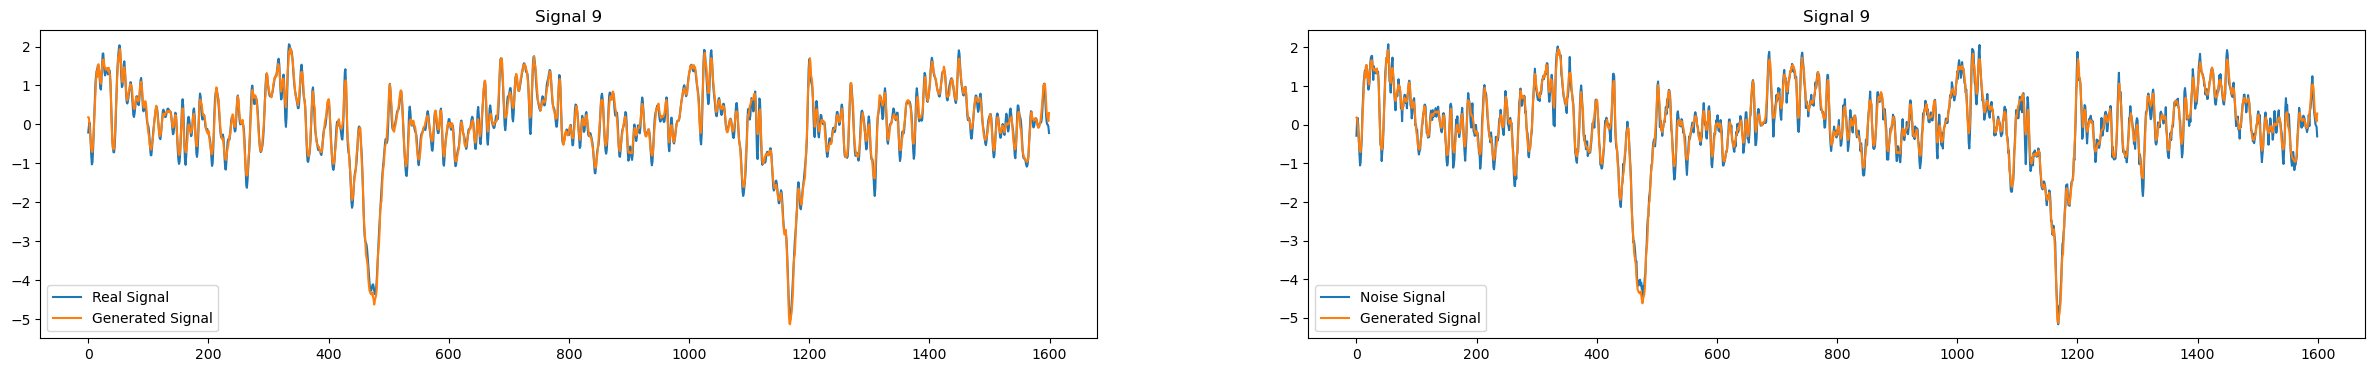

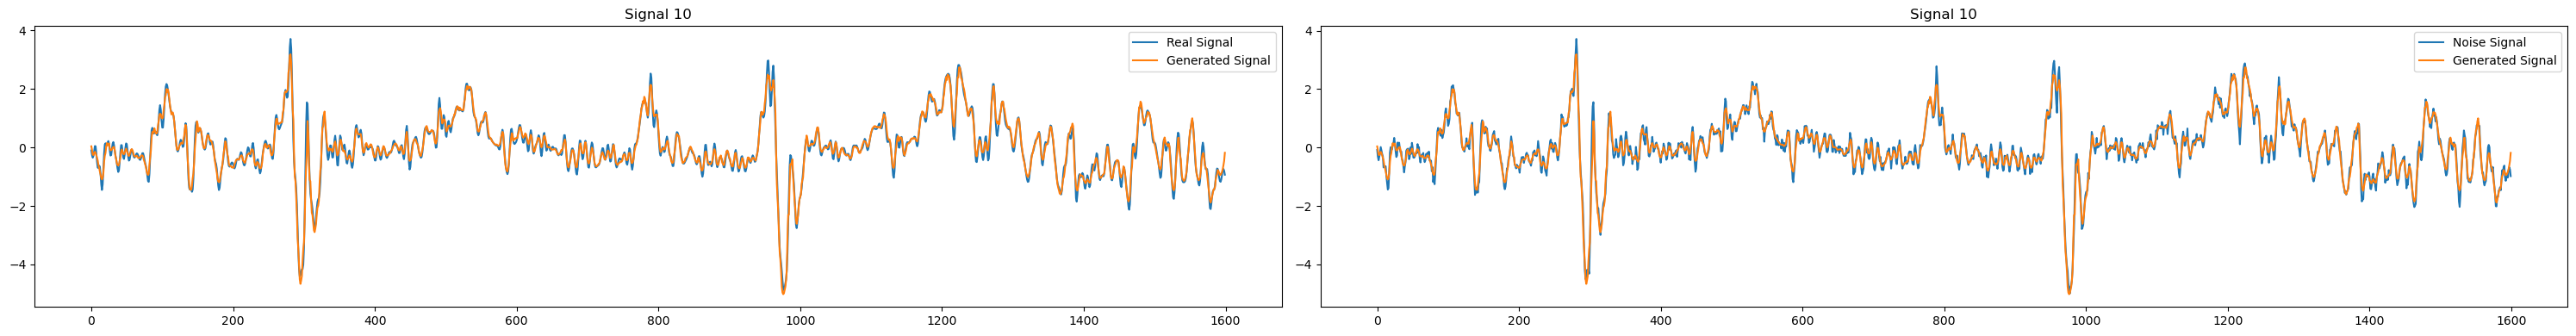

In [127]:
visualize_test_results(GN_01_test_loader)

---

alpha = 0.2

In [128]:
# 데이터셋과 데이터 로더 설정
GN_02_ecg_dataset = GN_ECGDataset(dataset_directory, 0.2)
# random_split을 사용하여 데이터셋을 나눕니다.
seed = torch.Generator().manual_seed(42)
train_dataset, test_dataset = random_split(GN_02_ecg_dataset, [train_size, test_size], generator=seed)

GN_02_train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
GN_02_test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [129]:
# 모델 및 최적화 알고리즘 설정
generator = Generator().to(device)
discriminator = Discriminator(signal_dim, noised_dim).to(device)

optimizer_G = torch.optim.Adam(generator.parameters(), lr=learning_rate)
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=learning_rate)

# 손실 함수(loss function)
criterion_GAN = nn.BCELoss(reduction='mean')
criterion_pixelwise = nn.L1Loss(reduction='mean')

In [130]:
train(GN_02_train_loader)

Epoch 1/200, Pixel Loss: 0.34961172938346863, Generator Loss: 5.334441661834717, Discriminator Loss: 0.35007065534591675
Epoch 2/200, Pixel Loss: 0.2404249906539917, Generator Loss: 3.6540470123291016, Discriminator Loss: 0.44867098331451416
Epoch 3/200, Pixel Loss: 0.1576339155435562, Generator Loss: 2.3280231952667236, Discriminator Loss: 0.6314139366149902
Epoch 4/200, Pixel Loss: 0.15151114761829376, Generator Loss: 2.3349480628967285, Discriminator Loss: 0.6561641693115234
Epoch 5/200, Pixel Loss: 0.14341819286346436, Generator Loss: 2.1166064739227295, Discriminator Loss: 0.6483153700828552
Epoch 6/200, Pixel Loss: 0.13013382256031036, Generator Loss: 2.07468318939209, Discriminator Loss: 0.6629120111465454
Epoch 7/200, Pixel Loss: 0.11099473387002945, Generator Loss: 1.8758057355880737, Discriminator Loss: 0.6877585649490356
Epoch 8/200, Pixel Loss: 0.10163141041994095, Generator Loss: 1.803631067276001, Discriminator Loss: 0.6882876753807068
Epoch 9/200, Pixel Loss: 0.114905029

In [131]:
evaluate(GN_02_test_loader)

Test set evaluation - Pixel Loss: 0.07957, Generator Loss: 1.53192, Discriminator Loss: 3.21087


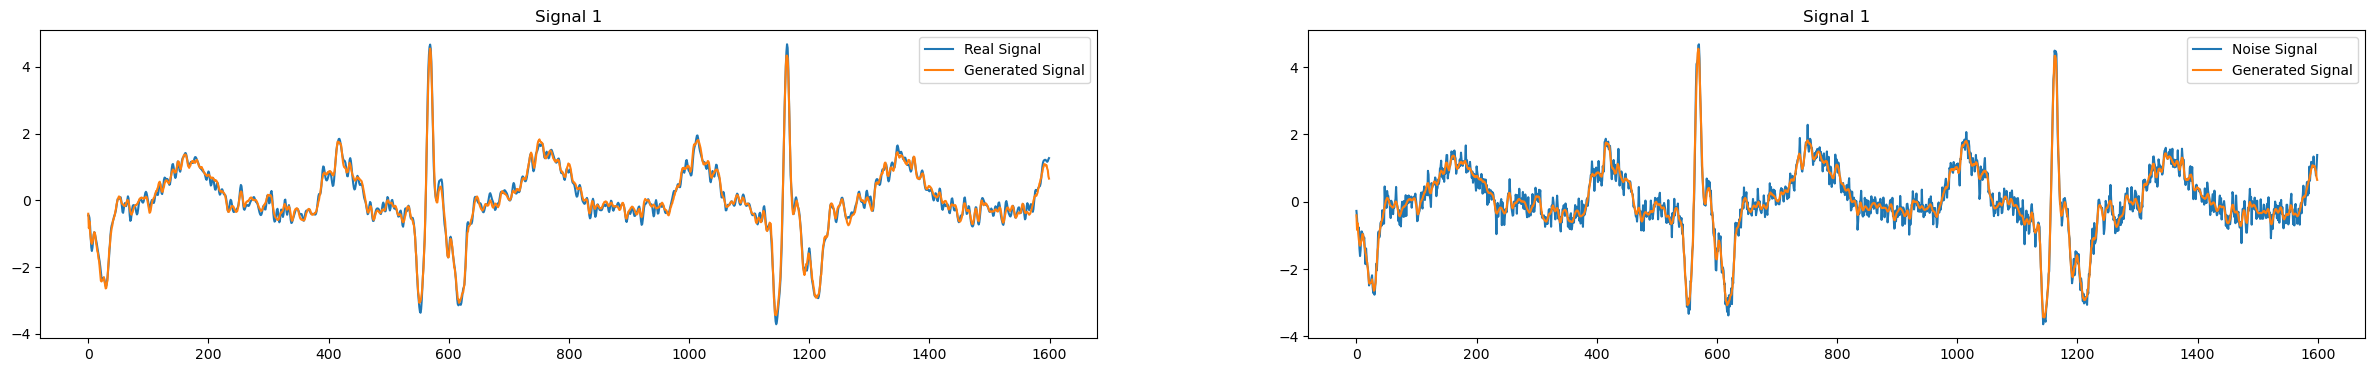

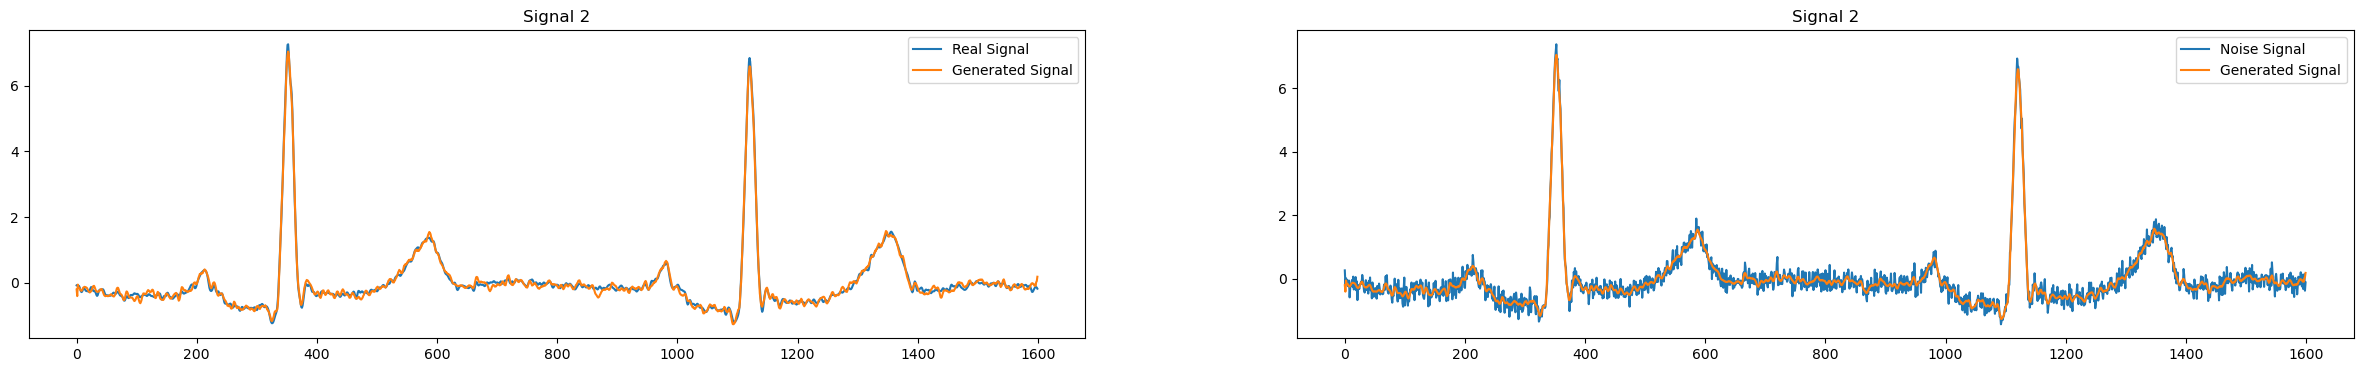

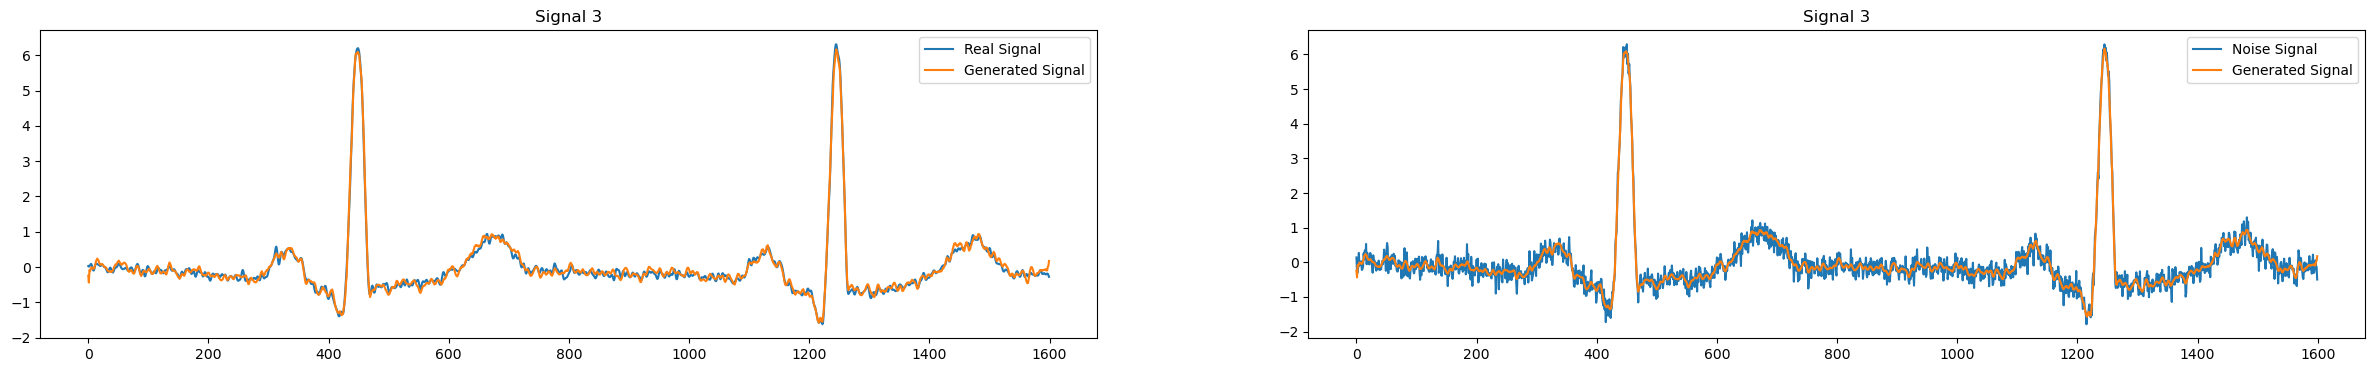

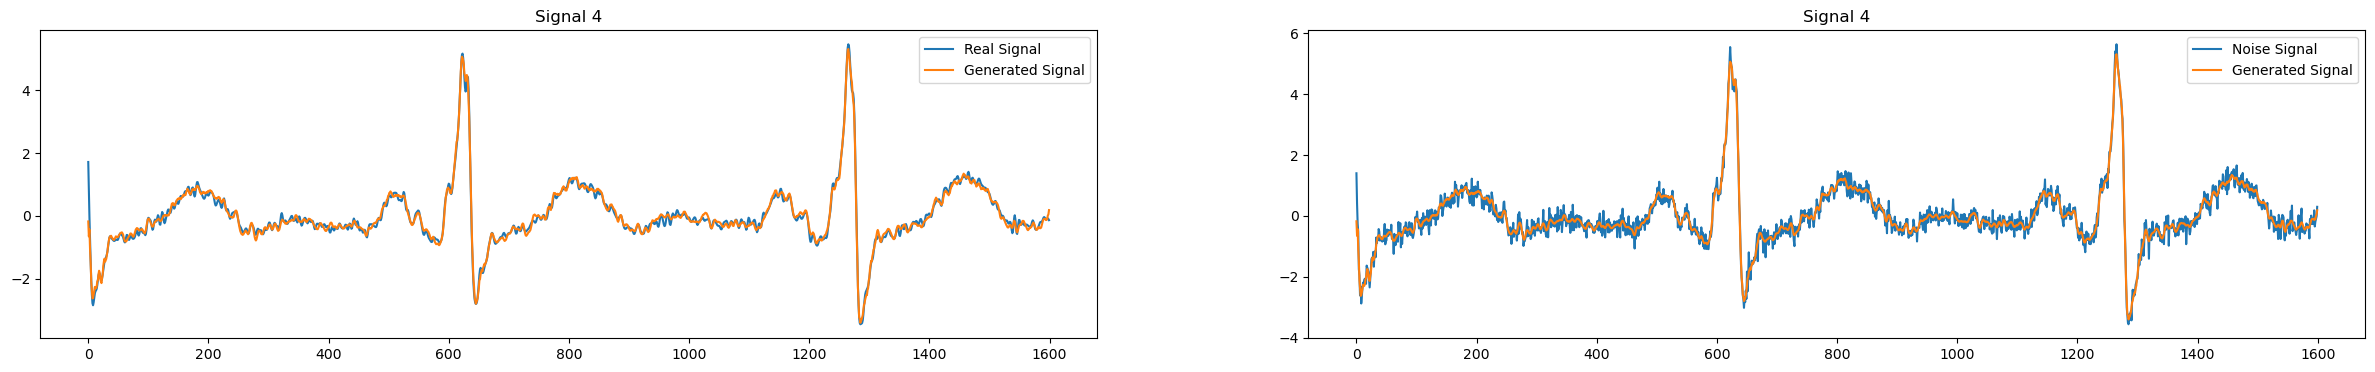

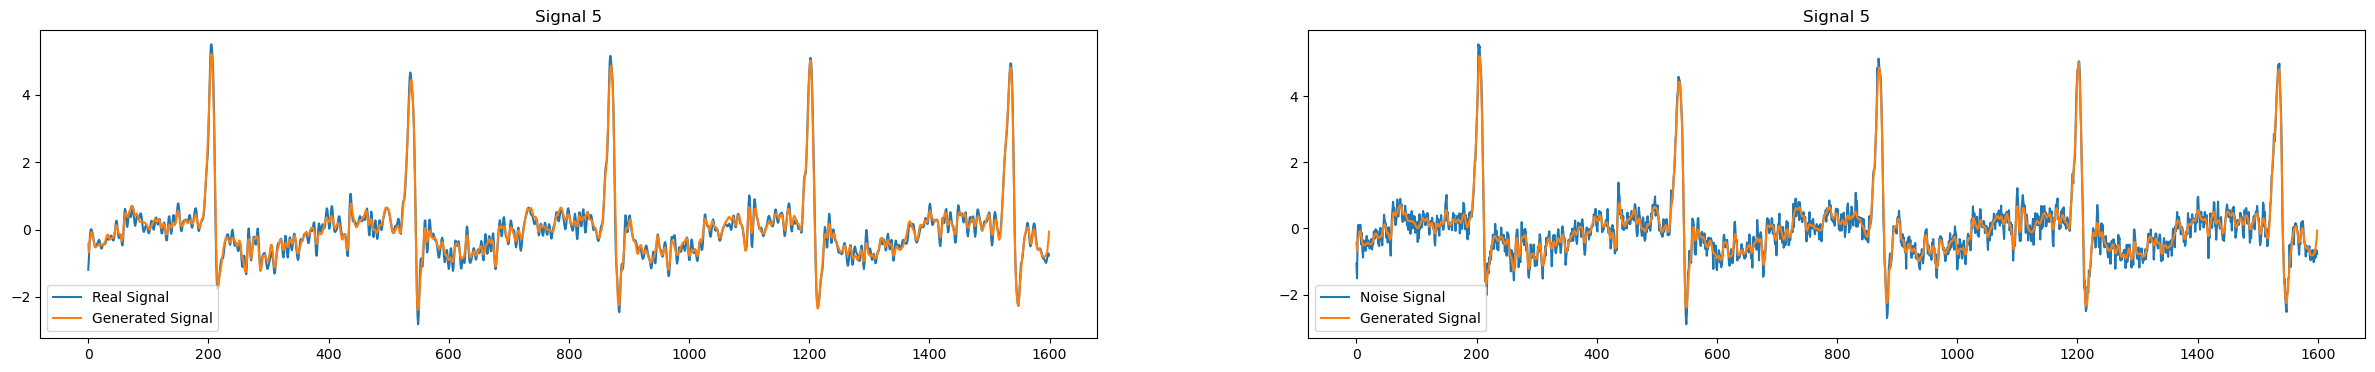

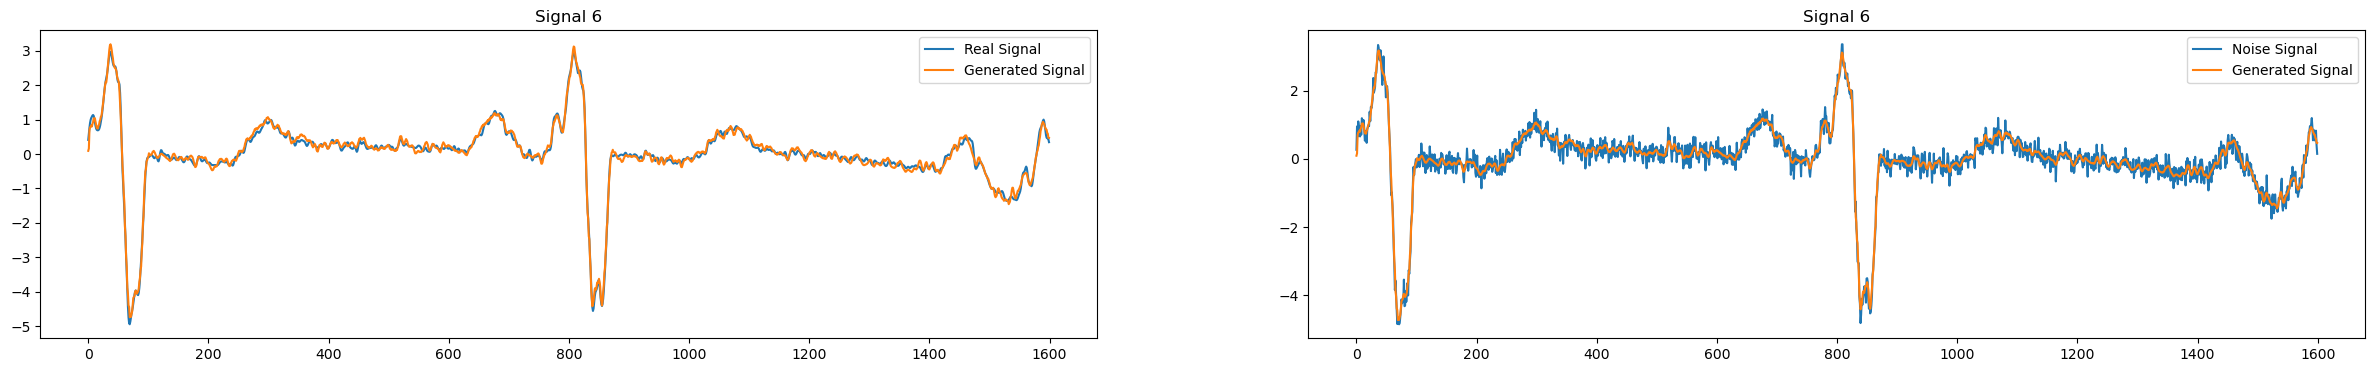

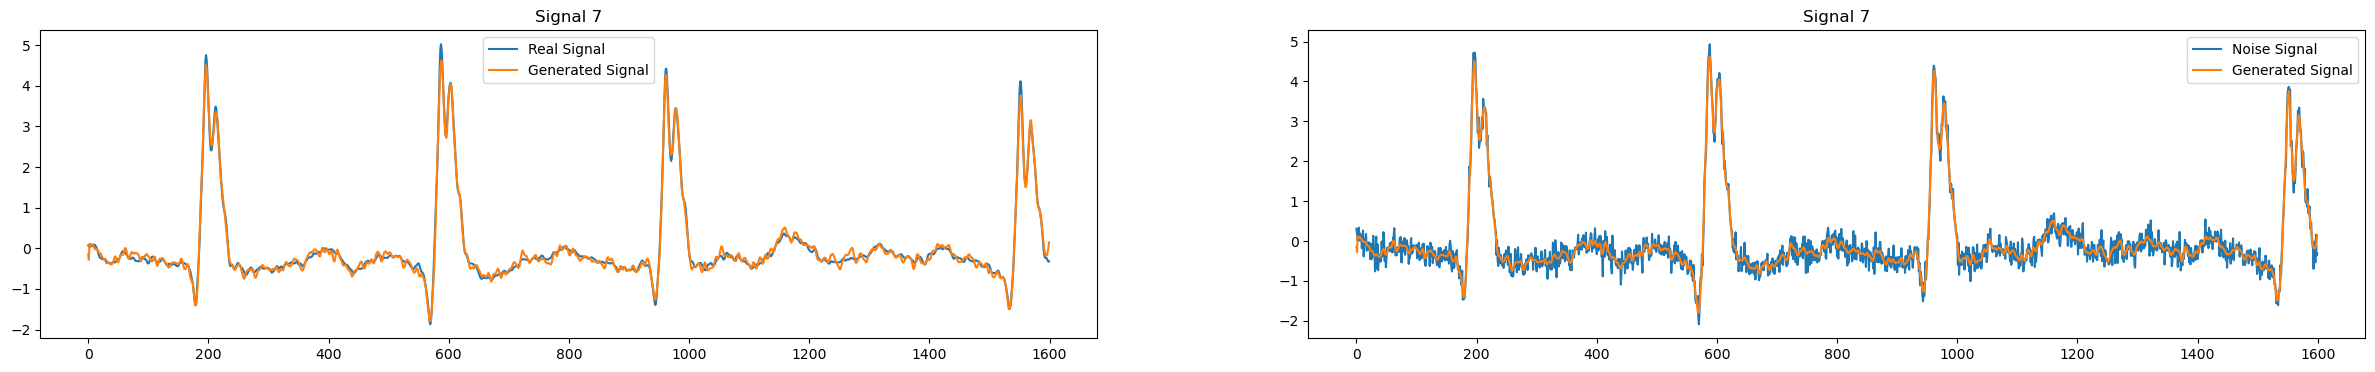

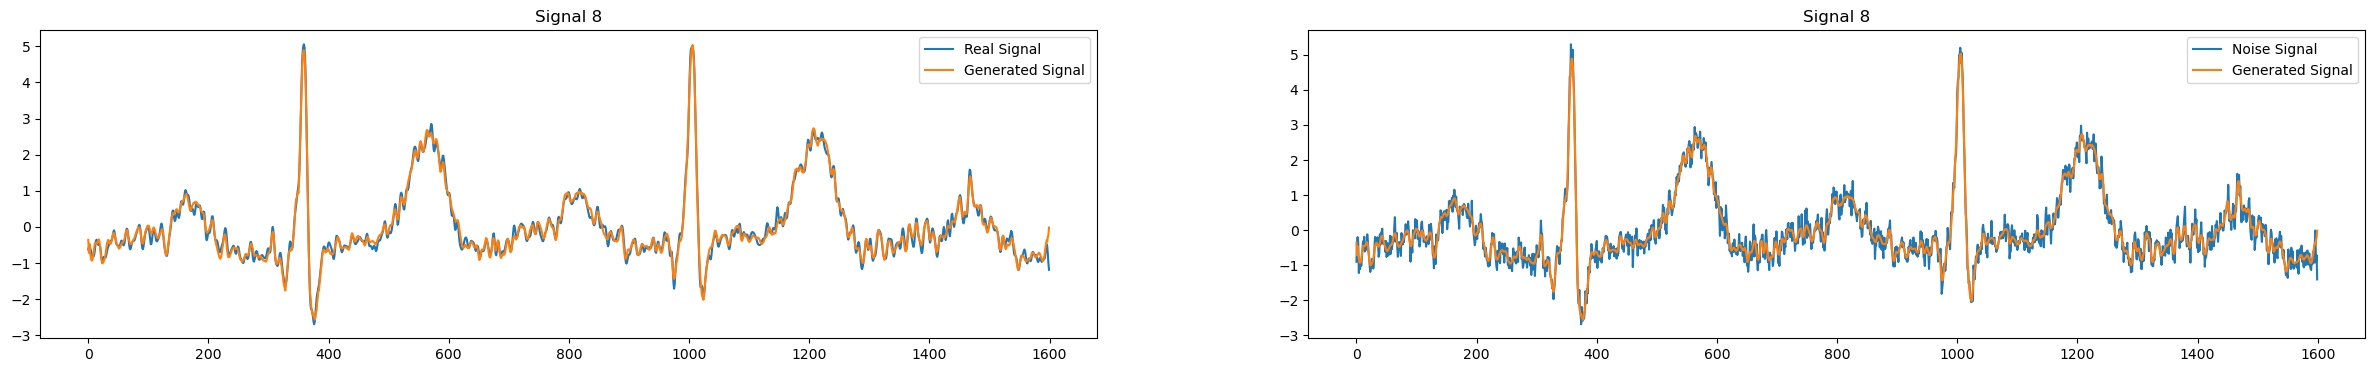

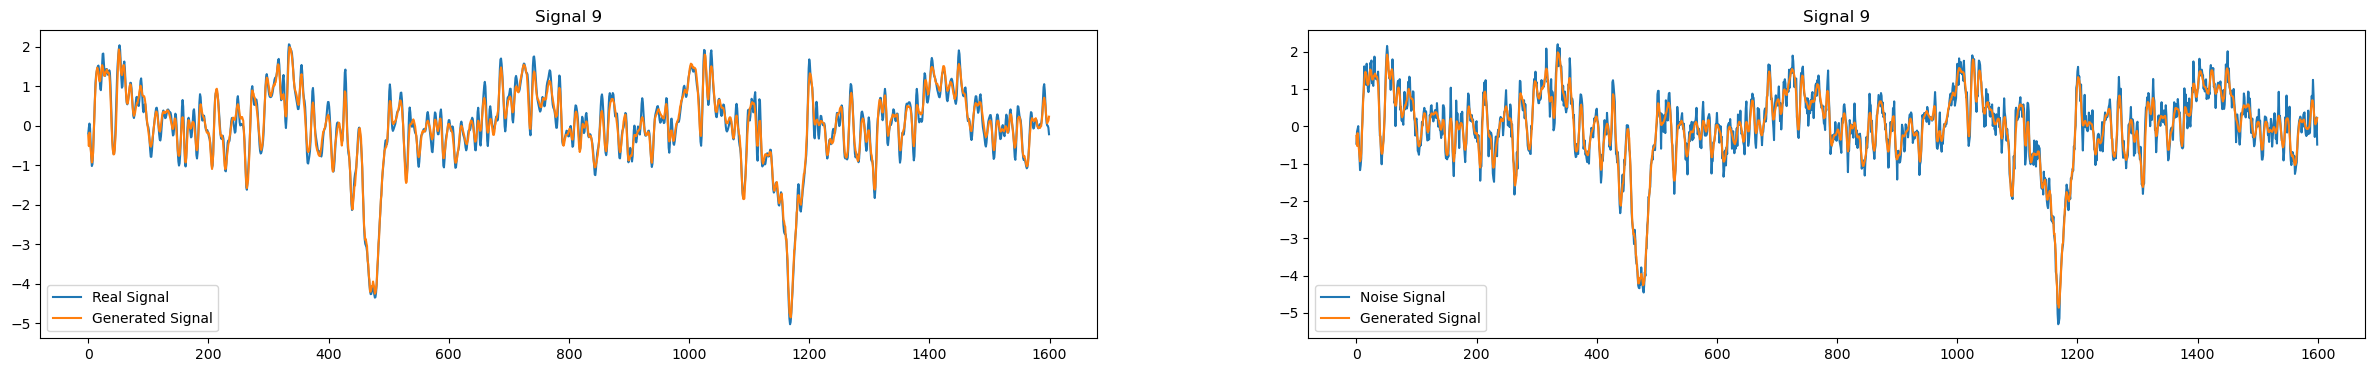

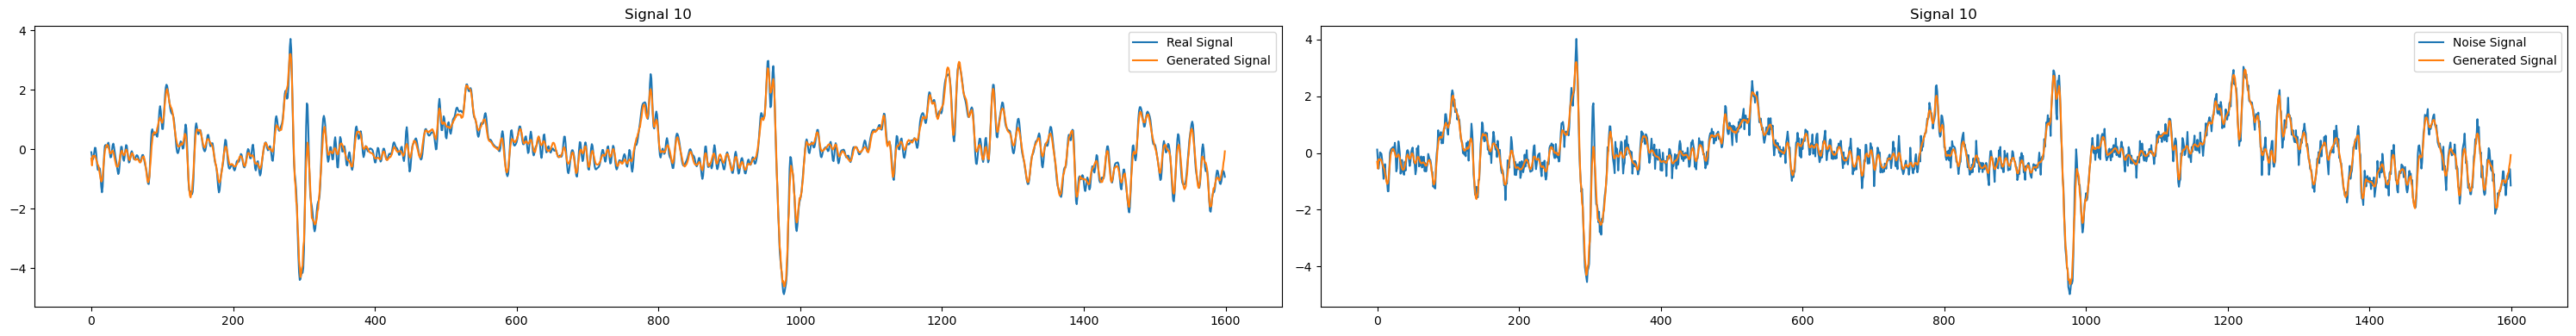

In [132]:
visualize_test_results(GN_02_test_loader)

---

## High Frequency Noise

In [133]:
class HF_ECGDataset(Dataset):
    def __init__(self, directory):
        self.data = []
        segment_length = 1600  # 2초 길이의 샘플 수

        # 모든 환자 디렉터리 반복
        for patient_num in range(1, 93):
            patient_dir = os.path.join(directory, f"patient{patient_num:03d}")
            seg_files = [f for f in os.listdir(patient_dir) if f.endswith('.dat')]
            
            for seg_file in seg_files:
                data_file = os.path.join(patient_dir, seg_file)
                header_file = os.path.join(patient_dir, seg_file.replace('.dat', '.hea'))
                
                num_channels, samples_per_channel, channel_names = self.parse_header(header_file)
                ii_index = channel_names.index('II')
                
                ecg_data = self.load_ecg_data(num_channels, samples_per_channel, data_file)
                
                # 각 세그먼트를 2초씩 잘라서 저장
                num_segments = 5
                for i in range(num_segments):
                    start = i * segment_length
                    end = start + segment_length
                    segment_data = {
                        "II": ecg_data[ii_index][start:end]
                    }

                    # II 채널 표준화
                    segment_data["II"] = (segment_data["II"] - np.mean(segment_data["II"])) / np.std(segment_data["II"])

                    # 랜덤 주파수의 high frequency noise 추가하여 II-Raw 생성
                    random_frequency = np.random.uniform(50, 100)
                    t = np.linspace(0, 2, segment_length, endpoint=False)
                    high_freq_noise = 0.1 * np.sin(2 * np.pi * random_frequency * t)  # 랜덤 주파수의 고주파 노이즈
                    segment_data["II-Raw"] = segment_data["II"] + high_freq_noise

                    self.data.append(segment_data)

    def parse_header(self, file_path):
        with open(file_path, 'r', encoding='latin1') as file:
            lines = file.readlines()
        num_channels = int(lines[0].split(' ')[1])
        samples_per_channel = int(lines[0].split(' ')[3])
        channel_names = []
        for line in lines[1:num_channels+1]:
            channel_info = line.split(' ')
            channel_names.append(channel_info[-1].strip())
        return num_channels, samples_per_channel, channel_names

    def load_ecg_data(self, num_channels, samples_per_channel, data_file):
        ecg_data = np.fromfile(data_file, dtype='int16')
        ecg_data = ecg_data.reshape((samples_per_channel, num_channels)).T
        return ecg_data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        return {key: torch.tensor(value, dtype=torch.float) for key, value in sample.items()}
    
    
# 데이터셋과 데이터 로더 설정
HF_ecg_dataset = HF_ECGDataset(dataset_directory)
# random_split을 사용하여 데이터셋을 나눕니다.
seed = torch.Generator().manual_seed(42)
train_dataset, test_dataset = random_split(HF_ecg_dataset, [train_size, test_size], generator=seed)

HF_train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
HF_test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [134]:
# 모델 및 최적화 알고리즘 설정
generator = Generator().to(device)
discriminator = Discriminator(signal_dim, noised_dim).to(device)

optimizer_G = torch.optim.Adam(generator.parameters(), lr=learning_rate)
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=learning_rate)

# 손실 함수(loss function)
criterion_GAN = nn.BCELoss(reduction='mean')
criterion_pixelwise = nn.L1Loss(reduction='mean')

In [135]:
train(HF_train_loader)

Epoch 1/200, Pixel Loss: 0.4553157389163971, Generator Loss: 5.737435817718506, Discriminator Loss: 0.8182418346405029
Epoch 2/200, Pixel Loss: 0.43292930722236633, Generator Loss: 5.664786338806152, Discriminator Loss: 0.5758312940597534
Epoch 3/200, Pixel Loss: 0.2287798672914505, Generator Loss: 4.017685413360596, Discriminator Loss: 0.3246397078037262
Epoch 4/200, Pixel Loss: 0.1432190090417862, Generator Loss: 3.392857074737549, Discriminator Loss: 0.272085964679718
Epoch 5/200, Pixel Loss: 0.12014182657003403, Generator Loss: 1.601657748222351, Discriminator Loss: 0.7260590195655823
Epoch 6/200, Pixel Loss: 0.09471075981855392, Generator Loss: 2.22987699508667, Discriminator Loss: 0.34538960456848145
Epoch 7/200, Pixel Loss: 0.10147017985582352, Generator Loss: 3.0610218048095703, Discriminator Loss: 0.31473639607429504
Epoch 8/200, Pixel Loss: 0.11003664135932922, Generator Loss: 2.5967297554016113, Discriminator Loss: 0.28774428367614746
Epoch 9/200, Pixel Loss: 0.1082616597414

In [136]:
evaluate(HF_test_loader)

Test set evaluation - Pixel Loss: 0.05795, Generator Loss: 6.48319, Discriminator Loss: 1.48042


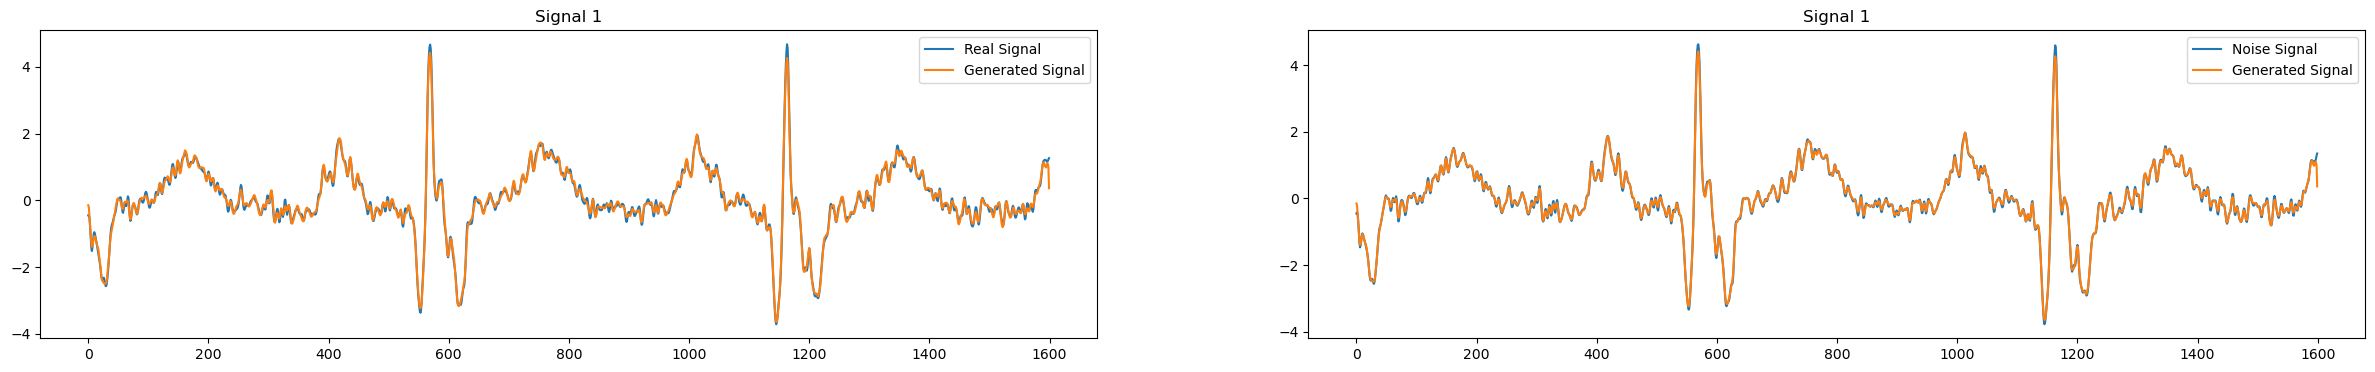

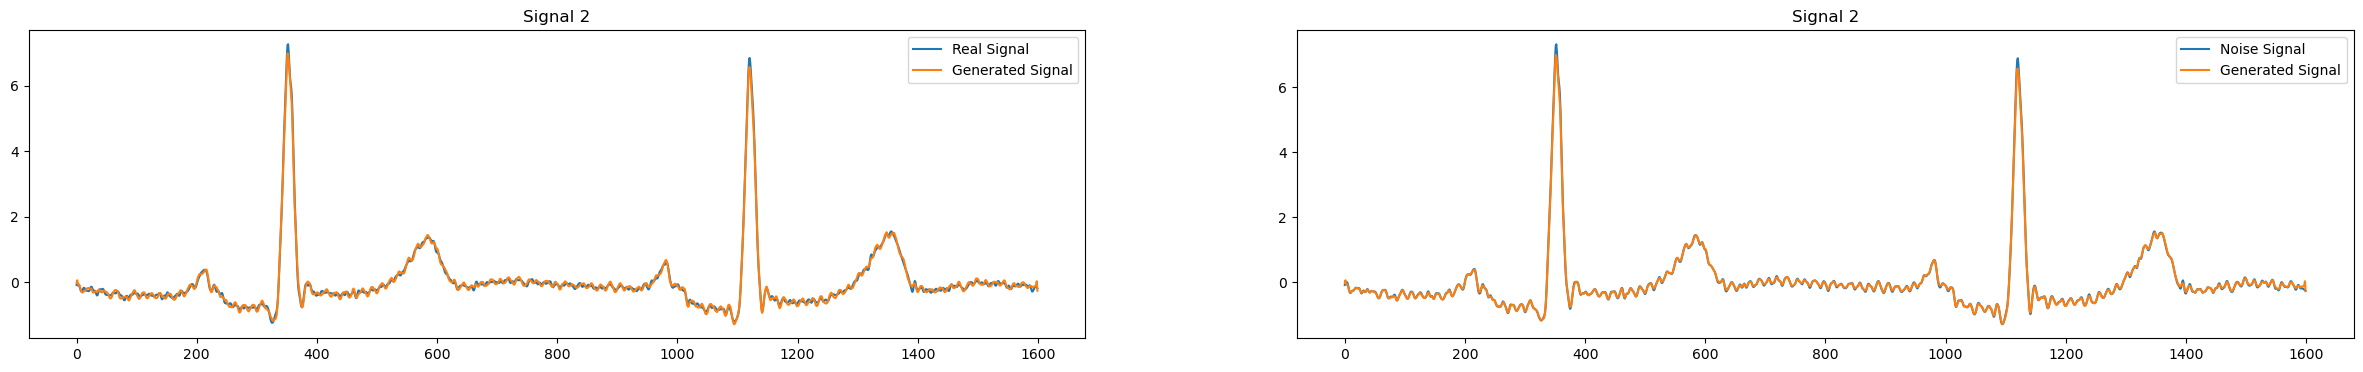

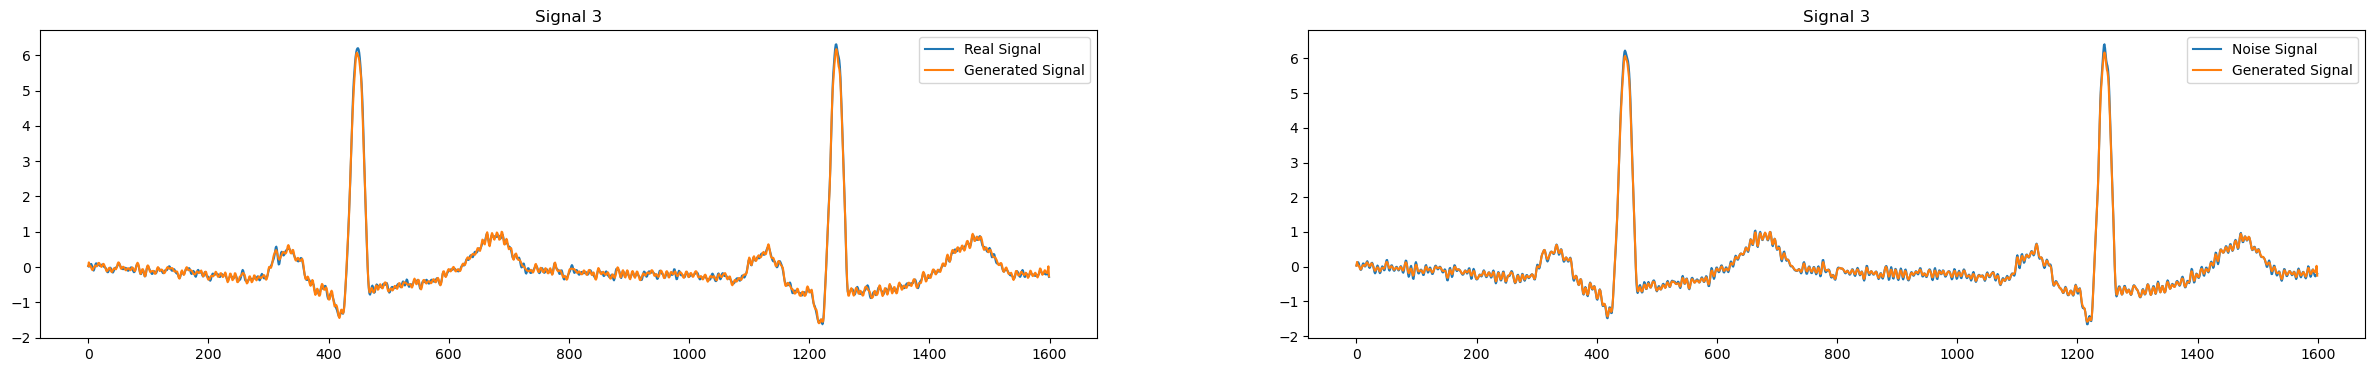

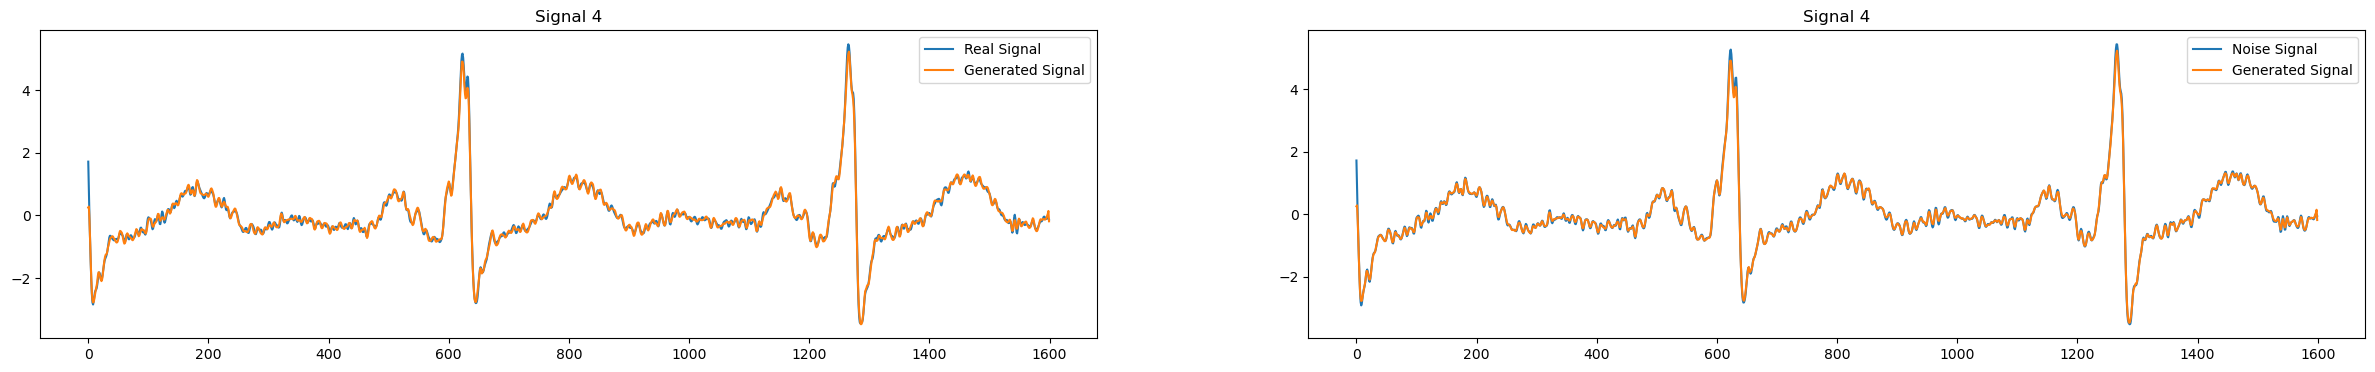

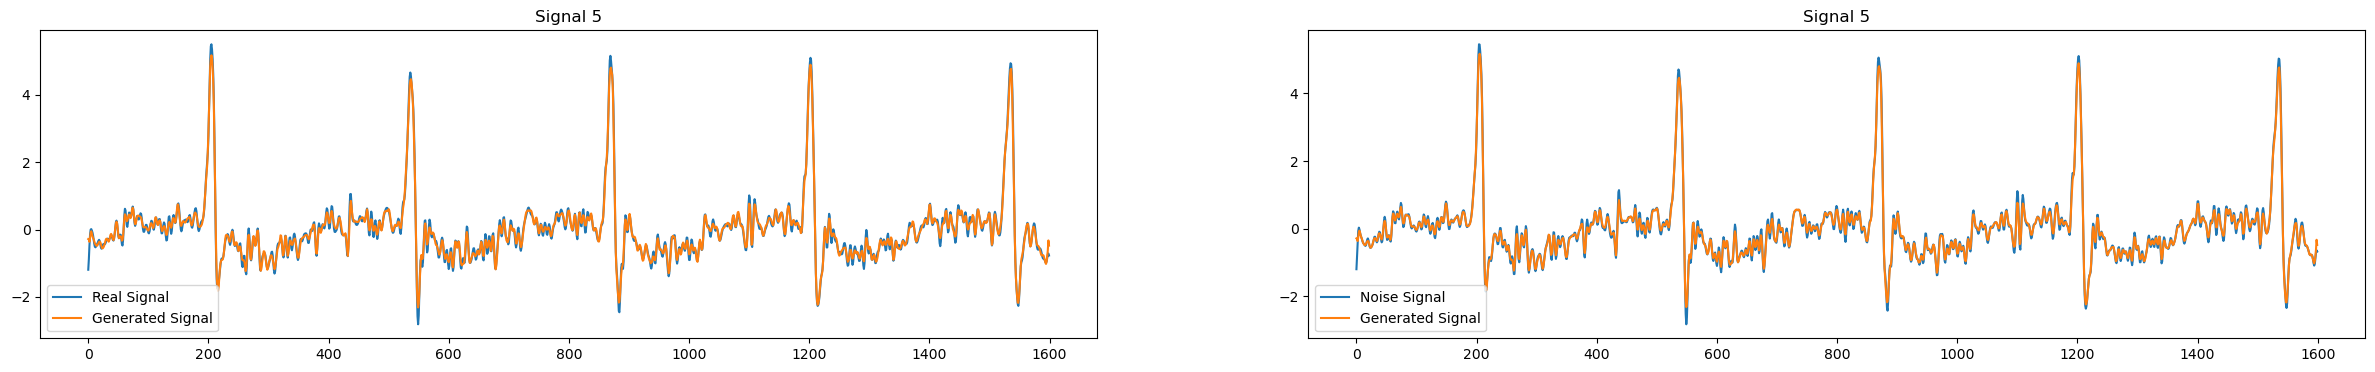

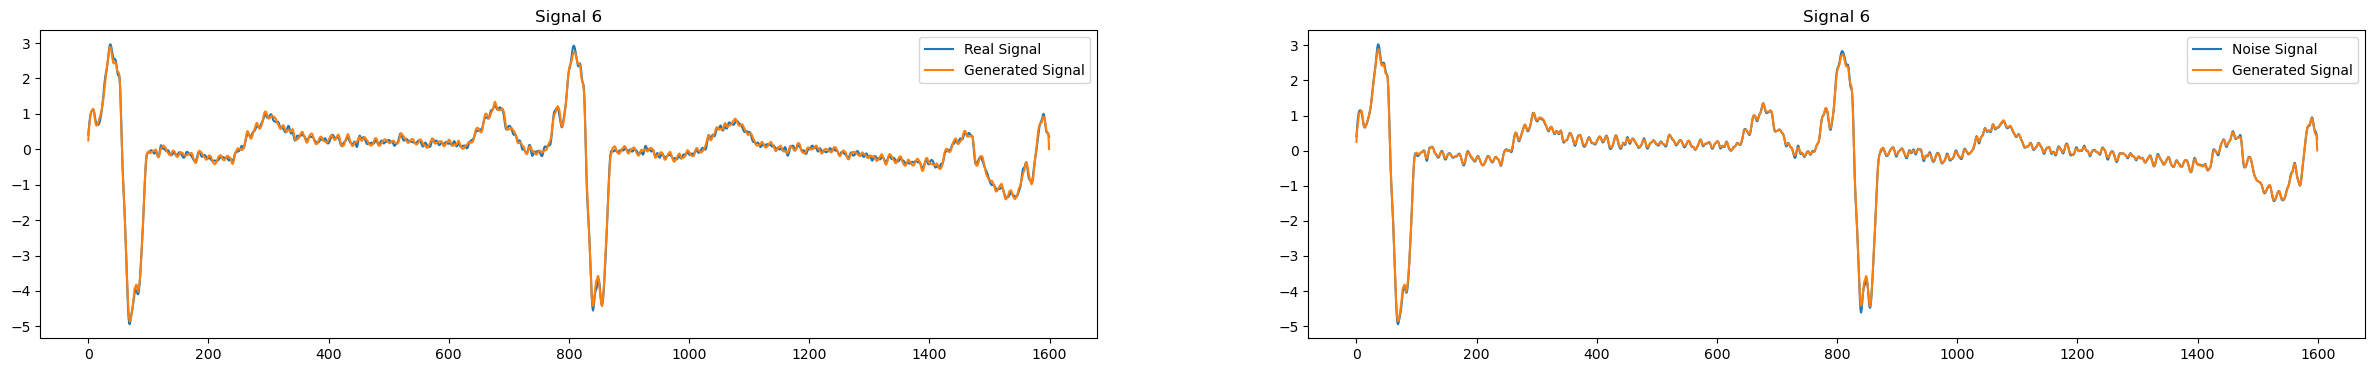

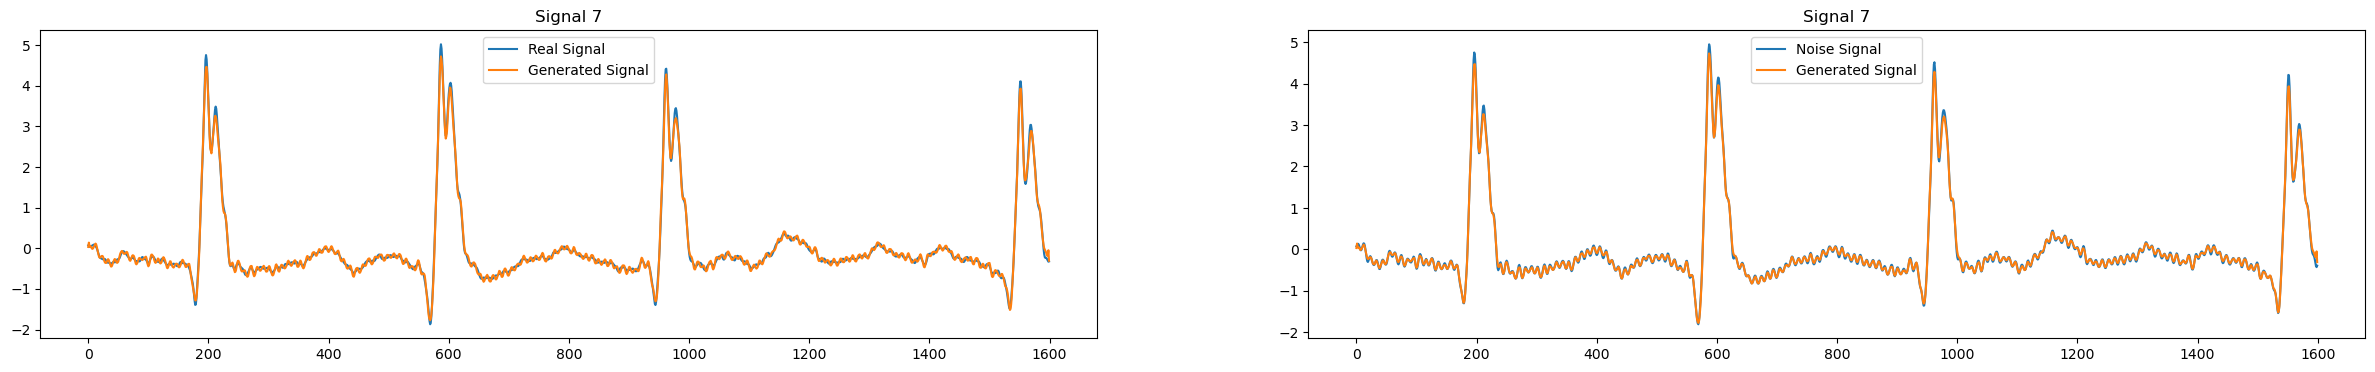

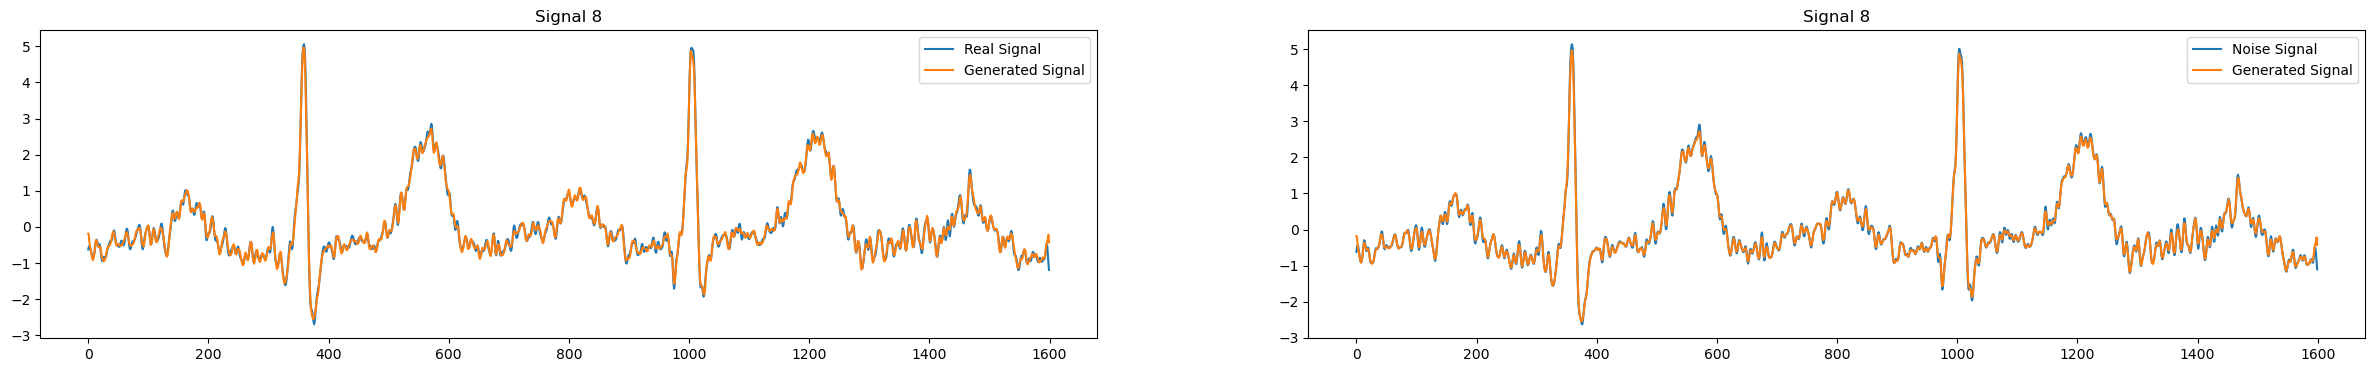

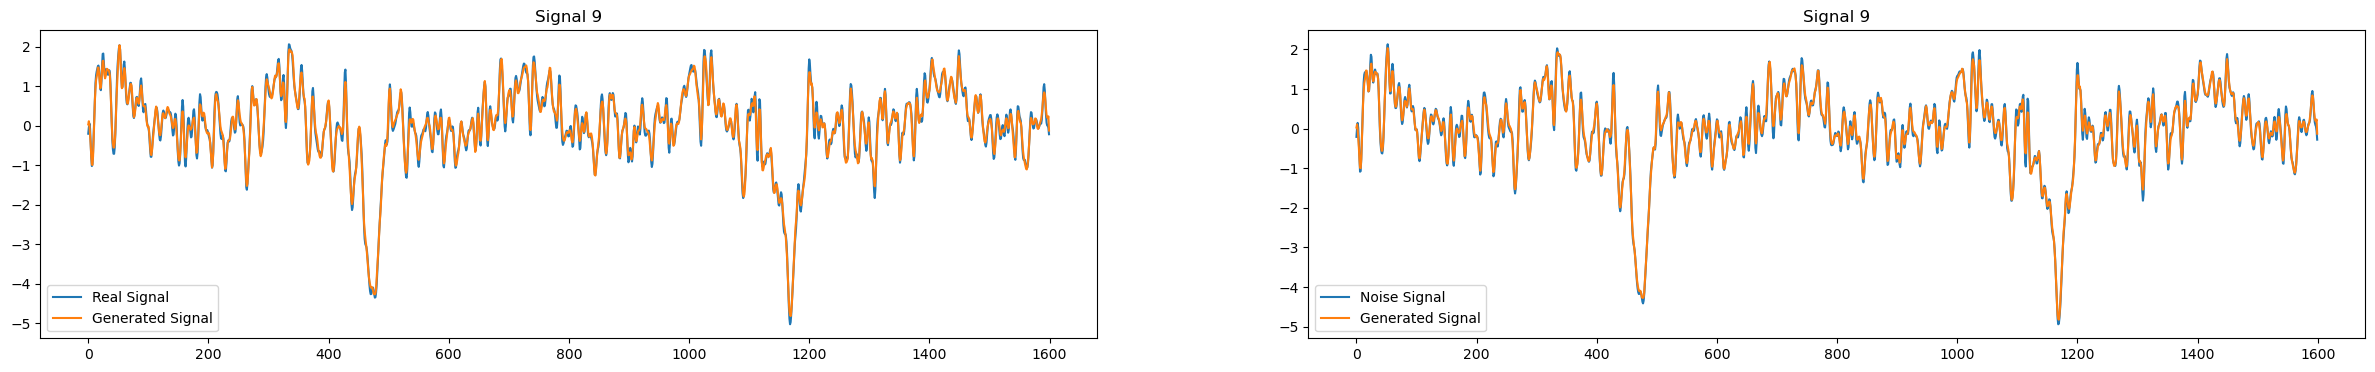

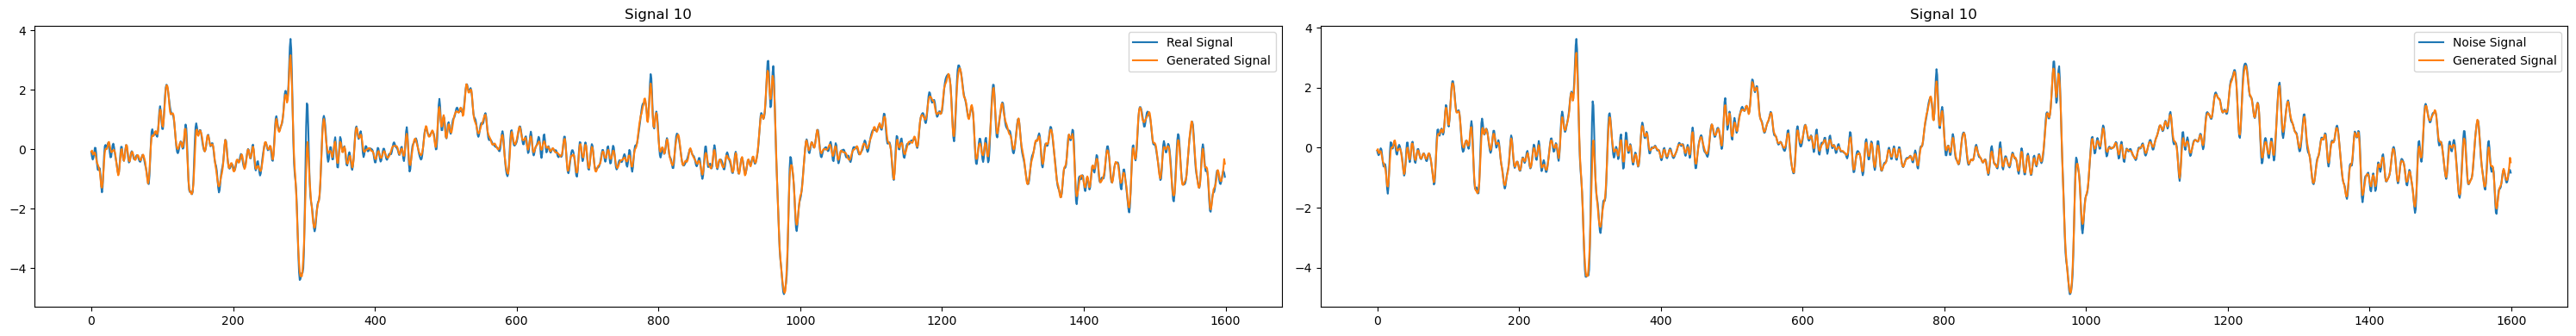

In [137]:
visualize_test_results(HF_test_loader)

---

## Combined Noise

In [138]:
class CN_ECGDataset(Dataset):
    def __init__(self, directory):
        self.data = []
        segment_length = 1600  # 2초 길이의 샘플 수

        # 모든 환자 디렉터리 반복
        for patient_num in range(1, 93):
            patient_dir = os.path.join(directory, f"patient{patient_num:03d}")
            seg_files = [f for f in os.listdir(patient_dir) if f.endswith('.dat')]
            
            for seg_file in seg_files:
                data_file = os.path.join(patient_dir, seg_file)
                header_file = os.path.join(patient_dir, seg_file.replace('.dat', '.hea'))
                
                num_channels, samples_per_channel, channel_names = self.parse_header(header_file)
                ii_index = channel_names.index('II')
                
                ecg_data = self.load_ecg_data(num_channels, samples_per_channel, data_file)
                
                # 각 세그먼트를 2초씩 잘라서 저장
                num_segments = 5
                for i in range(num_segments):
                    start = i * segment_length
                    end = start + segment_length
                    segment_data = {
                        "II": ecg_data[ii_index][start:end]
                    }

                    # II 채널 표준화
                    segment_data["II"] = (segment_data["II"] - np.mean(segment_data["II"])) / np.std(segment_data["II"])

                    # 랜덤 주파수의 high frequency noise와 Gaussian noise를 추가하여 II-Raw 생성
                    random_frequency = np.random.uniform(50, 100)
                    t = np.linspace(0, 2, segment_length, endpoint=False)
                    high_freq_noise = 0.1 * np.sin(2 * np.pi * random_frequency * t)  # 랜덤 주파수의 고주파 노이즈
                    noise = np.random.normal(0, 1, segment_length)                    # 가우시안 노이즈
                    segment_data["II-Raw"] = segment_data["II"] + high_freq_noise + 0.1*noise

                
                    self.data.append(segment_data)

    def parse_header(self, file_path):
        with open(file_path, 'r', encoding='latin1') as file:
            lines = file.readlines()
        num_channels = int(lines[0].split(' ')[1])
        samples_per_channel = int(lines[0].split(' ')[3])
        channel_names = []
        for line in lines[1:num_channels+1]:
            channel_info = line.split(' ')
            channel_names.append(channel_info[-1].strip())
        return num_channels, samples_per_channel, channel_names

    def load_ecg_data(self, num_channels, samples_per_channel, data_file):
        ecg_data = np.fromfile(data_file, dtype='int16')
        ecg_data = ecg_data.reshape((samples_per_channel, num_channels)).T
        return ecg_data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        return {key: torch.tensor(value, dtype=torch.float) for key, value in sample.items()}
    
    
# 데이터셋과 데이터 로더 설정
CN_ecg_dataset = CN_ECGDataset(dataset_directory)
# random_split을 사용하여 데이터셋을 나눕니다.
seed = torch.Generator().manual_seed(42)
train_dataset, test_dataset = random_split(CN_ecg_dataset, [train_size, test_size], generator=seed)

CN_train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
CN_test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [139]:
# 모델 및 최적화 알고리즘 설정
generator = Generator().to(device)
discriminator = Discriminator(signal_dim, noised_dim).to(device)

optimizer_G = torch.optim.Adam(generator.parameters(), lr=learning_rate)
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=learning_rate)

# 손실 함수(loss function)
criterion_GAN = nn.BCELoss(reduction='mean')
criterion_pixelwise = nn.L1Loss(reduction='mean')

In [140]:
train(CN_train_loader)

Epoch 1/200, Pixel Loss: 0.36274123191833496, Generator Loss: 5.64585018157959, Discriminator Loss: 0.2553214132785797
Epoch 2/200, Pixel Loss: 0.2134360522031784, Generator Loss: 3.3181586265563965, Discriminator Loss: 0.530658483505249
Epoch 3/200, Pixel Loss: 0.15517298877239227, Generator Loss: 2.699021100997925, Discriminator Loss: 0.43928027153015137
Epoch 4/200, Pixel Loss: 0.13326607644557953, Generator Loss: 2.885226249694824, Discriminator Loss: 0.3241864740848541
Epoch 5/200, Pixel Loss: 0.1265650987625122, Generator Loss: 2.4615159034729004, Discriminator Loss: 0.38315683603286743
Epoch 6/200, Pixel Loss: 0.1041572168469429, Generator Loss: 3.203939914703369, Discriminator Loss: 0.19862297177314758
Epoch 7/200, Pixel Loss: 0.10186000913381577, Generator Loss: 3.167912483215332, Discriminator Loss: 0.24718546867370605
Epoch 8/200, Pixel Loss: 0.10219115018844604, Generator Loss: 5.014994144439697, Discriminator Loss: 0.2750386893749237
Epoch 9/200, Pixel Loss: 0.102958656847

In [141]:
evaluate(CN_test_loader)

Test set evaluation - Pixel Loss: 0.07114, Generator Loss: 4.11575, Discriminator Loss: 1.37055


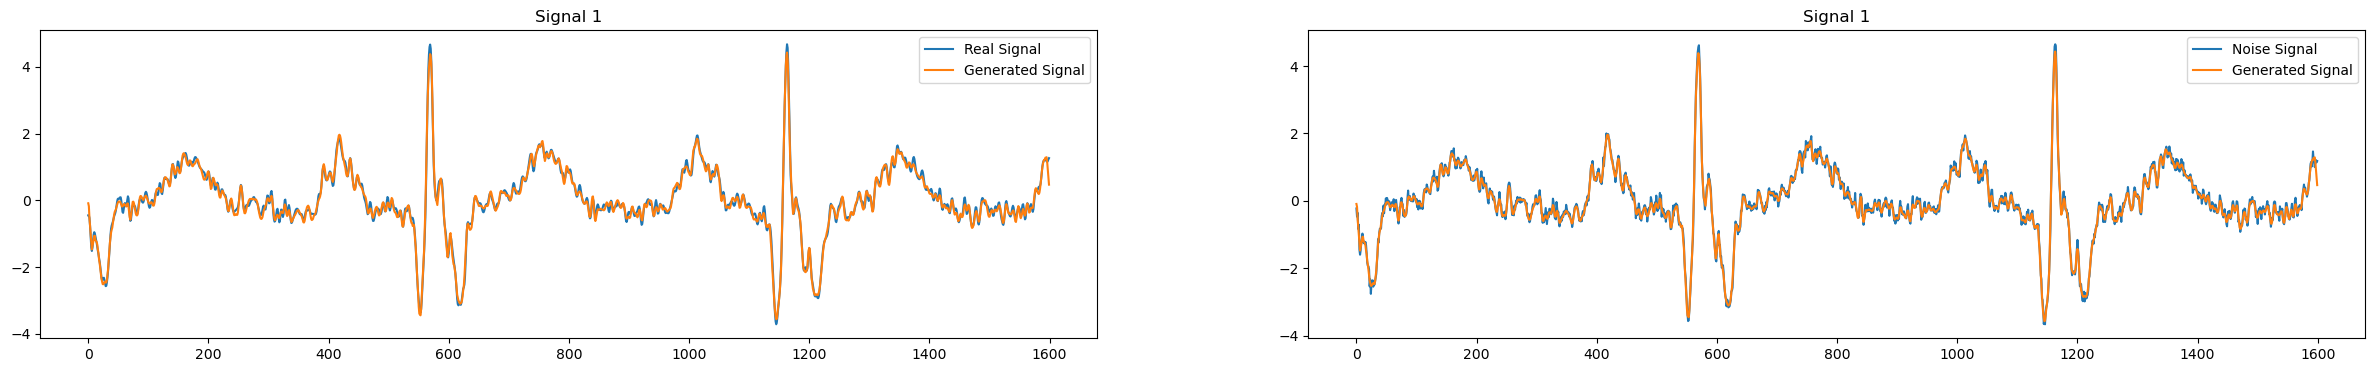

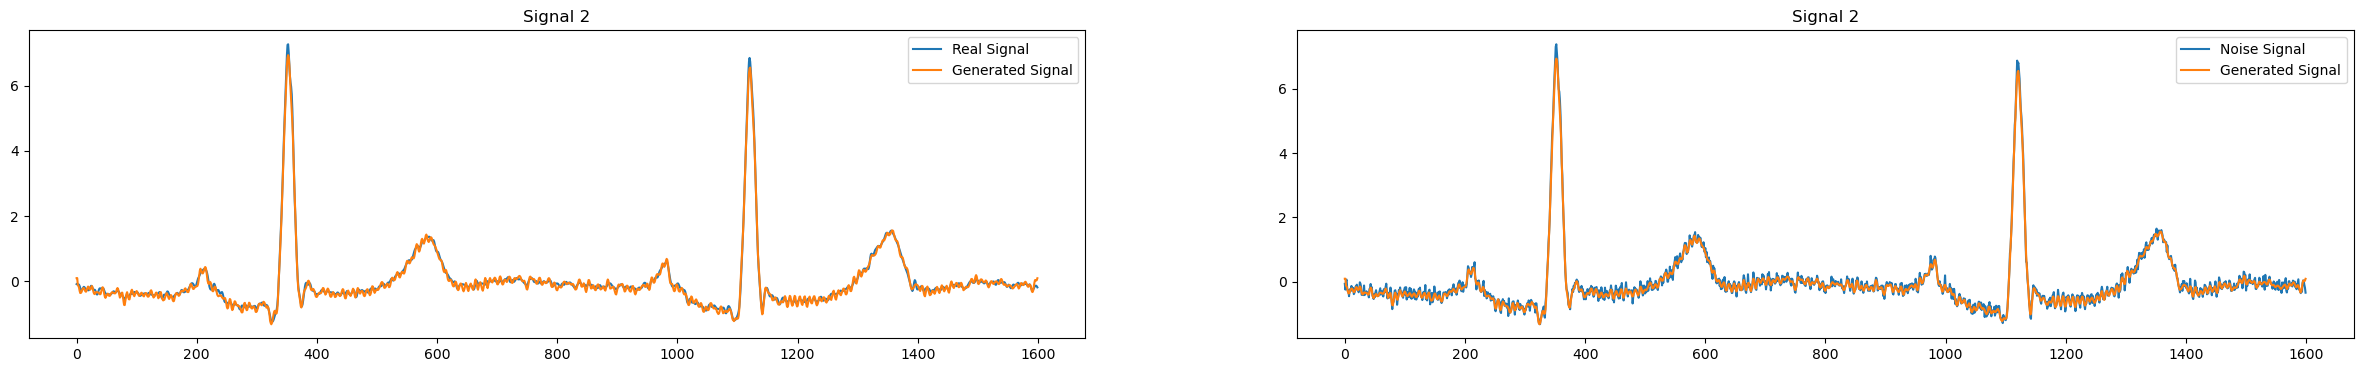

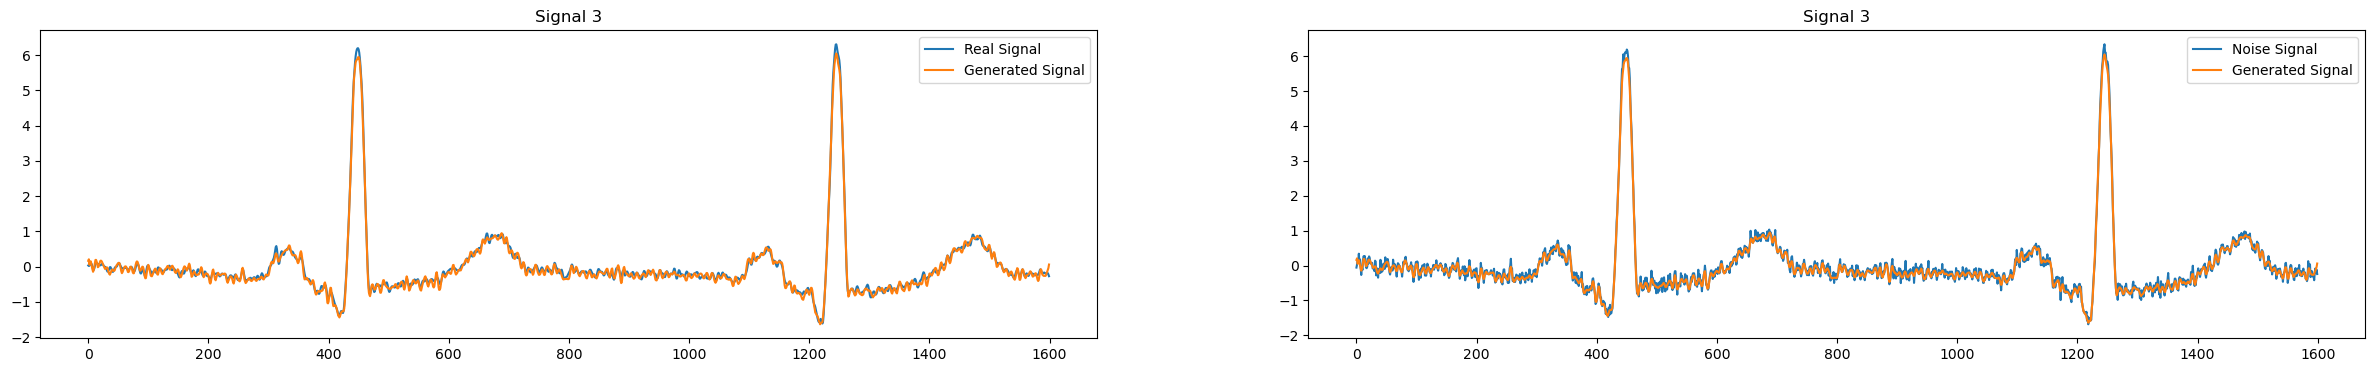

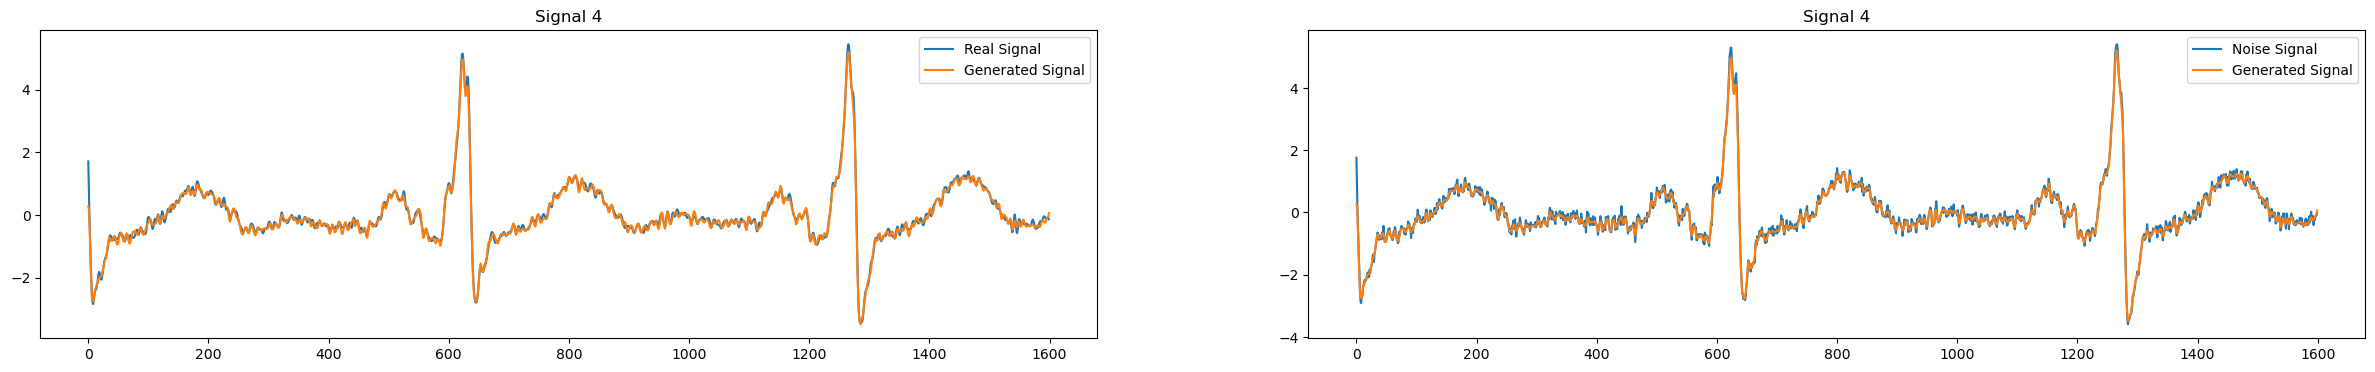

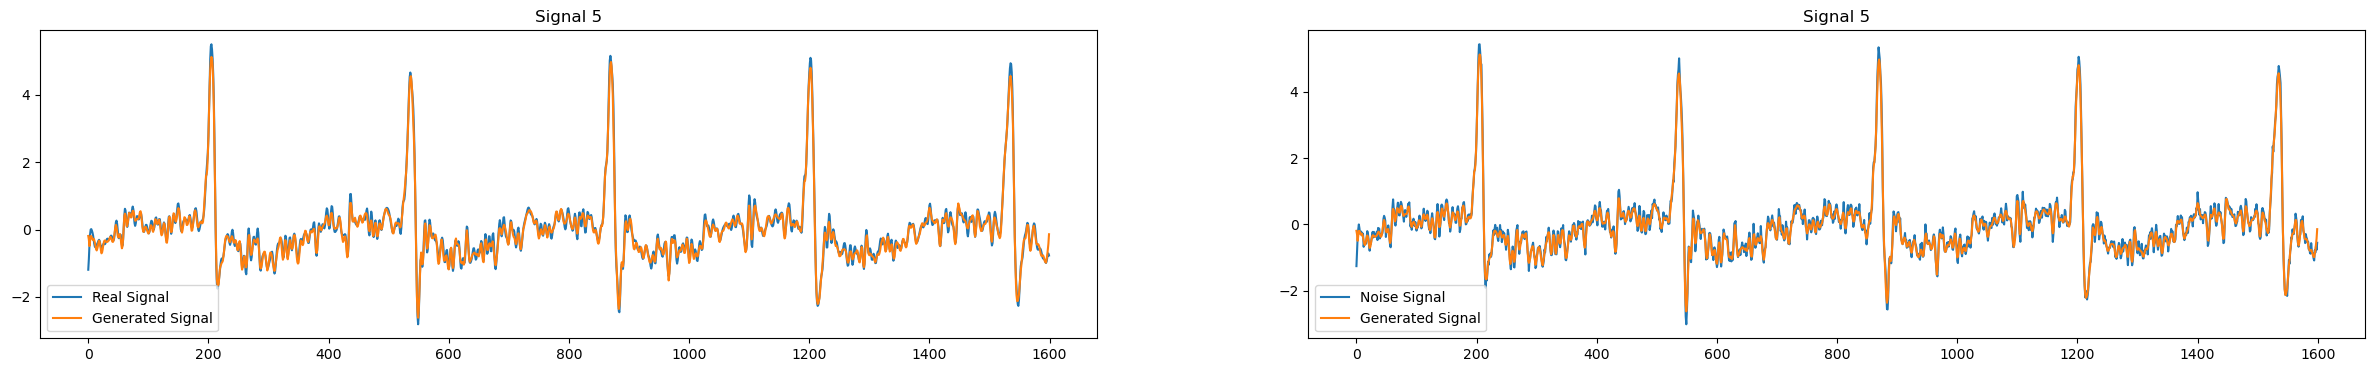

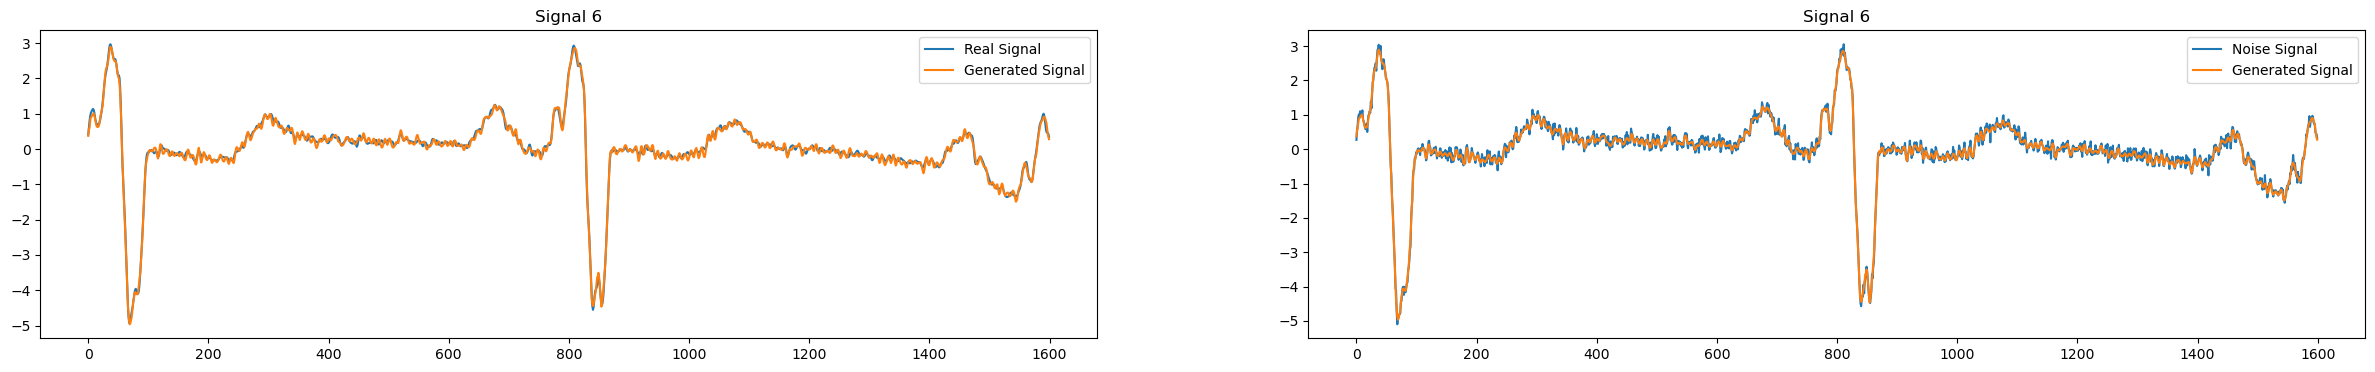

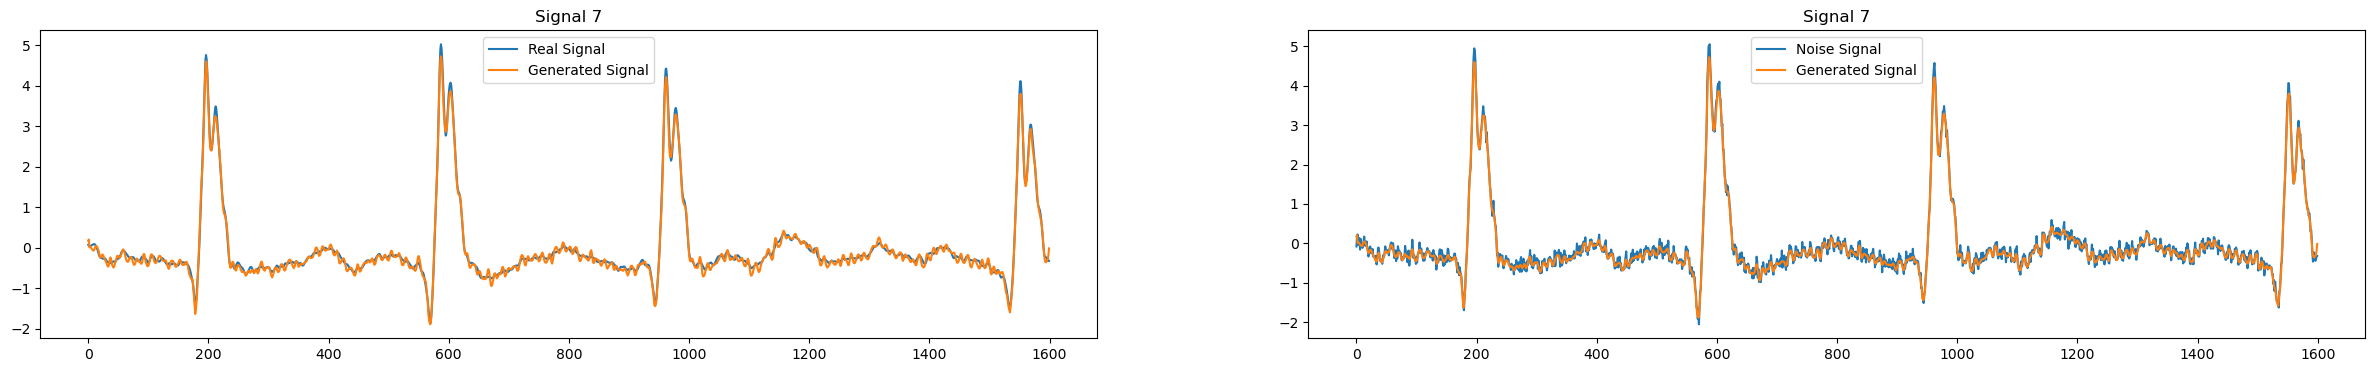

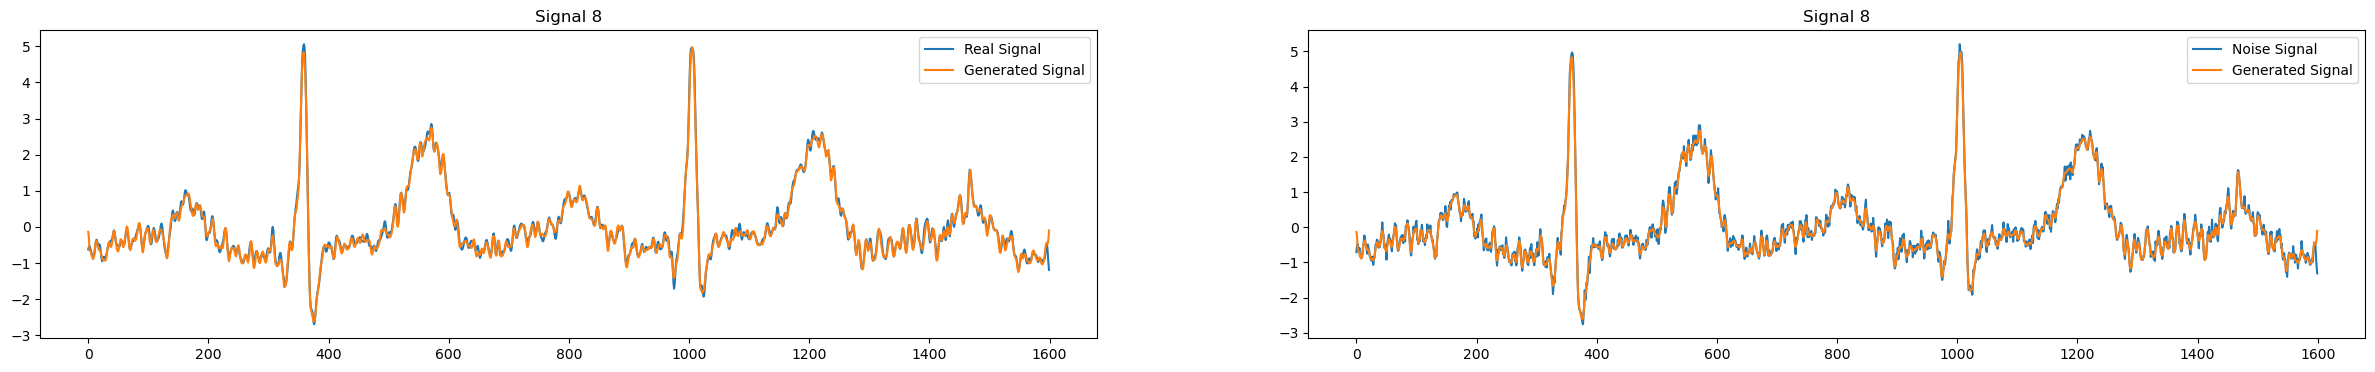

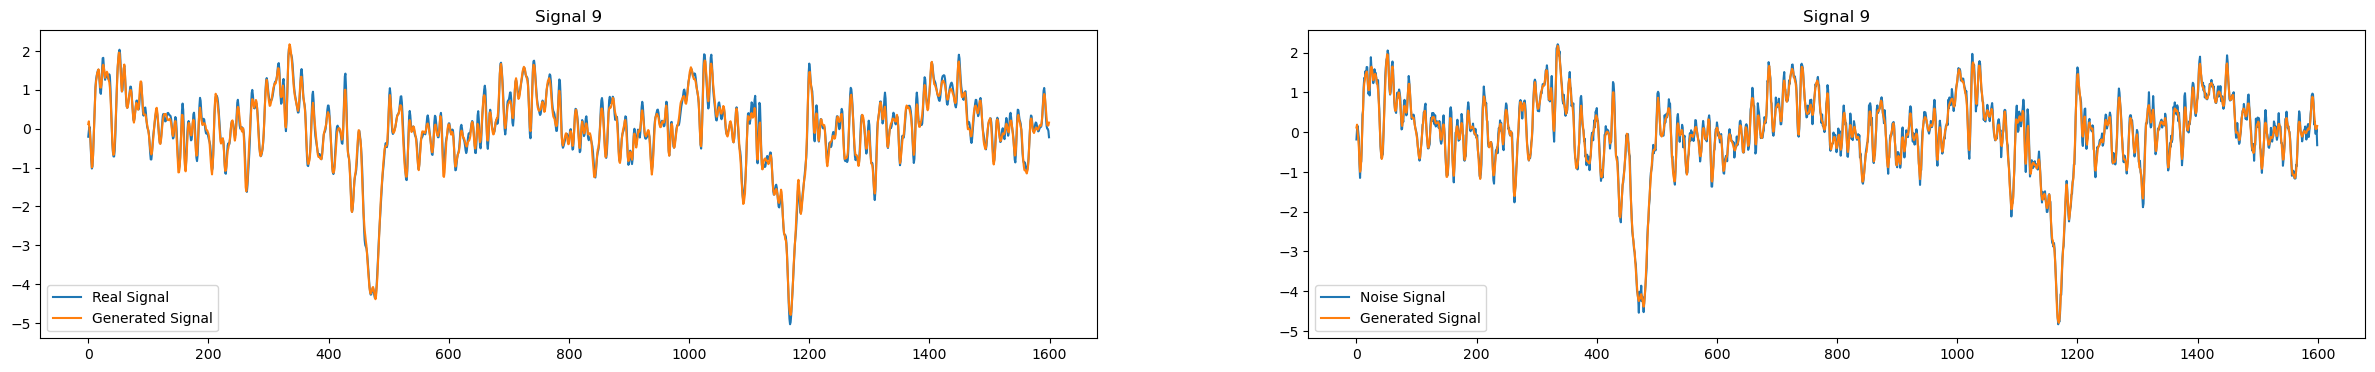

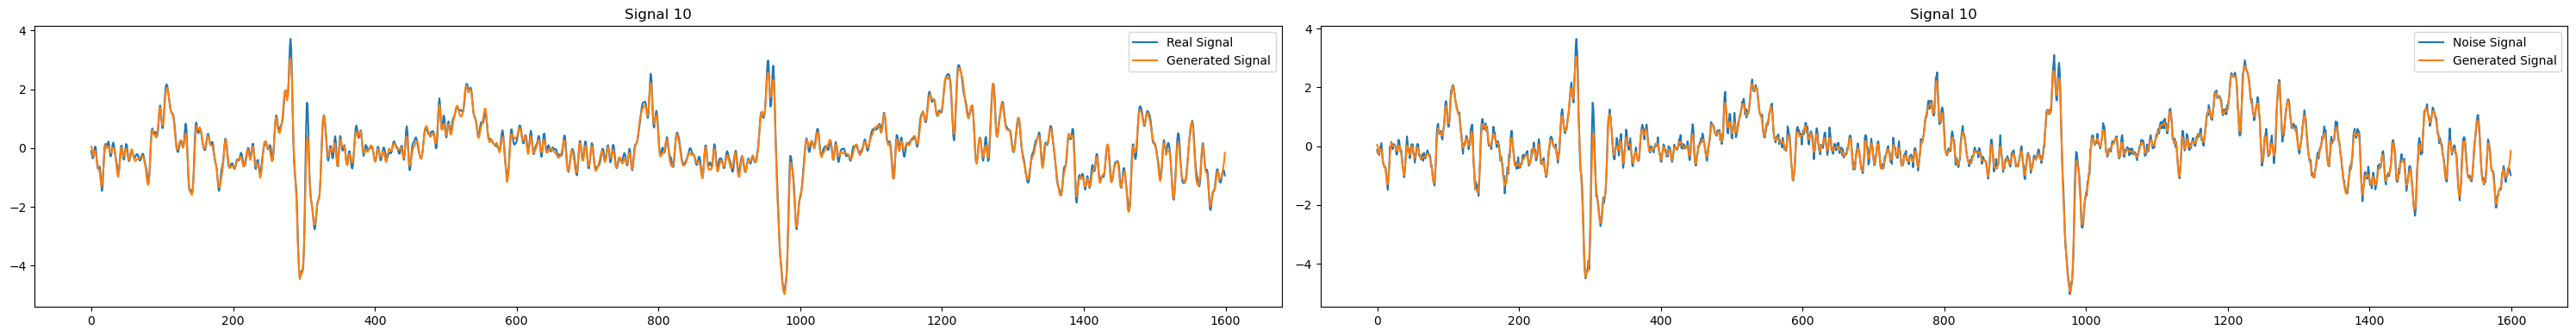

In [142]:
visualize_test_results(CN_test_loader)